In [16]:
# import psycopg2

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostRegressor

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer
from Model.Informer import Informer
from Model.Pyraformer import Pyraformer
from Model.N_BEATS import NBeats
from Model.NLinear import NLinear

from Dataset.District_Dataset import District_Dataset
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention
from Model.Informer_Attention import InformerAttention
from Model.Pyraformer_Attention import PyraformerAttention

from utils import RMSE, rmse, mse, mae, save_train_val_losses, early_stops, plot_train_val_losses
from Filling_missing import *

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# connection_info = "host=localhost dbname=postgres user=postgres password=hd219833 port=5432"
# conn = psycopg2.connect(connection_info)
# table_1_query = '''
#     SELECT * FROM building
#     '''
# table_2_query = '''
#     SELECT * FROM economy
#     '''
# table_3_query = '''
#     SELECT * FROM building_price
#     '''
# table_1 = pd.read_sql(table_1_query,conn) 
# table_2 = pd.read_sql(table_2_query,conn)
# table_3 = pd.read_sql(table_3_query,conn) 

table_1 = pd.read_csv('../вЇ░ВЮ┤ьё░/Table/table_1.csv') 
table_2 = pd.read_csv('../вЇ░ВЮ┤ьё░/Table/table_2.csv') 
table_3 = pd.read_csv('../вЇ░ВЮ┤ьё░/Table/table_3.csv') 

### Ж▓░ВИАВ╣ў В▒ёВџ░ЖИ░

In [2]:
old_and_new_dongs = {'ВџЕВѓ░вЈЎ5Ж░ђ':'ьЋюЖ░ЋвАювЈЎ','ьЋюЖ░ЋвАю2Ж░ђ':'ьЋюЖ░ЋвАювЈЎ','В░йвЈЎ':'В░йВаювЈЎ','вЈѕВЋћвЈЎ':'ВаЋвдЅвЈЎ','Ж▒░ВЌгвЈЎ':'ВюёвАђвЈЎ','вгИВаЋвЈЎ':'ВюёвАђвЈЎ','ВъЦВДђвЈЎ':'ВюёвАђвЈЎ','вгИв░░вЈЎ':'ВЏљьџевАювЈЎ','Вѓ░В▓ювЈЎ':'ВЏљьџевАювЈЎ','ВІаВ░йвЈЎ':'ВЏљьџевАювЈЎ','ВЏљьџевАю1Ж░ђ':'ВЏљьџевАювЈЎ','ьЎћЖ│АвЈЎ':'Вџ░ВъЦВѓ░вЈЎ','вѓ┤в░юВѓ░вЈЎ':'Вџ░ВъЦВѓ░вЈЎ','ВўЂвЊ▒ьЈгвЈЎ8Ж░ђ':'ВўЂвЊ▒ьЈгвЈЎ','ВќЉьЈЅвЈЎ3Ж░ђ':'ВќЉьЈЅвЈЎ','ВЋѕВЋћвЈЎ1Ж░ђ':'ВЋѕВЋћвЈЎ','ВЌ╝вдгвЈЎ':'ВЋёьўёвЈЎ','Вё▒ВѕўвЈЎ2Ж░ђ':'Вё▒Вѕў2Ж░ђВаю2вЈЎ','Вё▒ВѕўвЈЎ1Ж░ђ':'Вё▒Вѕў1Ж░ђВаю1вЈЎ','ВцЉвЈЎ':'Вё▒Вѓ░вЈЎ','вЁИЖ│аВѓ░вЈЎ':'ВёюЖхљвЈЎ','ВІаВаЋвЈЎ':'ВёюЖ░ЋвЈЎ','В░йВаёвЈЎ':'ВёюЖ░ЋвЈЎ','Вѓ╝ВёавЈЎ4Ж░ђ':'Вѓ╝ВёавЈЎ','в│┤вгИвЈЎ3Ж░ђ':'в│┤вгИвЈЎ','вЈЎВєївгИвЈЎ7Ж░ђ':'вЈЎВёавЈЎ','вІ╣Вѓ░вЈЎ4Ж░ђ':'вІ╣Вѓ░Ваю2вЈЎ','вІ╣Вѓ░вЈЎ5Ж░ђ':'вІ╣Вѓ░Ваю2вЈЎ','вІ╣Вѓ░вЈЎ':'вІ╣Вѓ░Ваю2вЈЎ','вІ╣Вѓ░вЈЎ3Ж░ђ':'вІ╣Вѓ░Ваю1вЈЎ','вІ╣Вѓ░вЈЎ1Ж░ђ':'вІ╣Вѓ░Ваю1вЈЎ','вІ╣Вѓ░вЈЎ2Ж░ђ':'вІ╣Вѓ░Ваю1вЈЎ','в│ИвЈЎ':'вЁИвЪЅВДёвЈЎ','ВІаВѕўвЈЎ':'вЁИЖ│аВѓ░вЈЎ','вїђьЮЦвЈЎ':'вЁИЖ│аВѓ░вЈЎ','ЖИѕьўИвЈЎ4Ж░ђ':'ЖИѕьўИвЈЎ','ЖИѕьўИвЈЎ2Ж░ђ':'ЖИѕьўИвЈЎ','ВХЕвг┤вАю4Ж░ђ':'Ж┤ЉьЮгвЈЎ','в░ЕьЎћвЈЎ':'Ж│хьЋГвЈЎ','вЈёьЎћвЈЎ':'Ж│хвЇЋвЈЎ','ВІаЖ│хвЇЋвЈЎ':'Ж│хвЇЋвЈЎ','ВЮ╝ВЏљвЈЎ':'Ж░юьЈгвЈЎ'}
def change_dongs(location):
    parts = location.split(' ')
    if parts[2] in old_and_new_dongs:
        parts[2] = old_and_new_dongs[parts[2]]
    return ' '.join(parts)
table_1['location'] = table_1['location'].apply(change_dongs)

scaler = StandardScaler()
table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]] = scaler.fit_transform(table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]])
scaler.fit(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]][:135])
table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]] = scaler.transform(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]])

table_merge = pd.merge(table_1, table_3, how='left', on='aid')
table_merge = pd.merge(table_merge, table_2, how='left', on='did')
table_merge.sort_values(by='did',inplace=True)

input_values = table_merge[[cols for cols in table_merge.columns if cols not in ['aid','location','name','did','year','month','price']]].values
output_values = table_merge[['price']].values * 0.0001

In [3]:
# Ж▓░ВИАВ╣ў вХёВёЮ
print("=== Ж▓░ВИАВ╣ў вХёВёЮ ===")
print(f"ВаёВ▓┤ вЇ░ВЮ┤ьё░ Ж░юВѕў: {len(table_merge)}")
print(f"Price Ж▓░ВИАВ╣ў Ж░юВѕў: {table_merge['price'].isna().sum()}")
print(f"Ж▓░ВИАВ╣ў в╣ёВюе: {table_merge['price'].isna().sum() / len(table_merge) * 100:.2f}%")

# Ж░Ђ aidв│ё вЇ░ВЮ┤ьё░ Ж░юВѕў ьЎЋВЮИ
aid_counts = table_merge.groupby('aid').size()
print(f"\nЖ░Ђ ВЋёьїїьіИв│ё вЇ░ВЮ┤ьё░ Ж░юВѕў:")
print(aid_counts.describe())

# aid==0 вЇ░ВЮ┤ьё░ ьЎЋВЮИ
aid_0_data = table_merge[table_merge['aid'] == 0].copy()
aid_0_data = aid_0_data.sort_values(['year', 'month'])
print(f"\naid==0 вЇ░ВЮ┤ьё░:")
print(aid_0_data[['aid', 'year', 'month', 'price']].head(20))

=== Ж▓░ВИАВ╣ў вХёВёЮ ===
ВаёВ▓┤ вЇ░ВЮ┤ьё░ Ж░юВѕў: 60369
Price Ж▓░ВИАВ╣ў Ж░юВѕў: 0
Ж▓░ВИАВ╣ў в╣ёВюе: 0.00%

Ж░Ђ ВЋёьїїьіИв│ё вЇ░ВЮ┤ьё░ Ж░юВѕў:
count    705.000000
mean      85.629787
std       48.863597
min        1.000000
25%       48.000000
50%       79.000000
75%      121.000000
max      210.000000
dtype: float64

aid==0 вЇ░ВЮ┤ьё░:
    aid  year  month    price
0     0  2006      1  67000.0
1     0  2006      2  66000.0
2     0  2006      3  73875.0
3     0  2006      4  83000.0
4     0  2006      5  85000.0
5     0  2006      7  80300.0
6     0  2006      9  77500.0
7     0  2006     10  89125.0
8     0  2006     11  93000.0
9     0  2007      7  87700.0
10    0  2007      8  88500.0
11    0  2008      5  85000.0
12    0  2008      6  86850.0
13    0  2008      7  88000.0
14    0  2008     10  85000.0
15    0  2008     11  66000.0
16    0  2009      2  74000.0
17    0  2009      3  78250.0
18    0  2009      4  79350.0
19    0  2009      5  83000.0


In [4]:
# ВѕўВаЋвљю ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒ ьЋеВѕў
def create_complete_dataset_from_merge(table_merge, start_year=2019, start_month=1, end_year=2023, end_month=12):
    """
    ЖИ░ВА┤ в│ЉьЋЕвљю вЇ░ВЮ┤ьё░вЦ╝ ЖИ░в░ўВю╝вАю ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░вЦ╝ ВЃЮВё▒
    """
    print("=== в│ЉьЋЕ вЇ░ВЮ┤ьё░ ЖИ░в░ў ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒ ВцЉ ===")
    
    # 1. вфевЊа Ж░ђвіЦьЋю вѓаВДю ВА░ьЋЕ ВЃЮВё▒
    all_dates = []
    current_year = start_year
    current_month = start_month
    
    while current_year < end_year or (current_year == end_year and current_month <= end_month):
        all_dates.append({'year': current_year, 'month': current_month})
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
    
    print(f"В┤Ю {len(all_dates)}Ж░юВЮў ВІюЖ░ё ьЈгВЮИьіИ ВЃЮВё▒ ({start_year}-{start_month} ~ {end_year}-{end_month})")
    
    # 2. вфевЊа ВЋёьїїьіИ ID Ж░ђВаИВўцЖИ░
    unique_aids = table_merge['aid'].unique()
    print(f"В┤Ю {len(unique_aids)}Ж░юВЮў ВЋёьїїьіИ")
    
    # 3. Ж░Ђ ВЋёьїїьіИВЌљ вїђьЋю ЖИ░в│И ВаЋв│┤вЦ╝ в»Ивдг ВХћВХю (В▓Ф в▓ѕВДИ ваѕВйћвЊю ЖИ░Вцђ)
    apartment_base_info = {}
    for aid in unique_aids:
        apt_data = table_merge[table_merge['aid'] == aid].iloc[0]
        apartment_base_info[aid] = apt_data.to_dict()
    
    # 4. вфевЊа ВЋёьїїьіИ ├Ќ вфевЊа вѓаВДю ВА░ьЋЕ ВЃЮВё▒
    complete_data = []
    
    for aid in unique_aids:
        base_info = apartment_base_info[aid]
        
        for date_info in all_dates:
            # ьЋ┤вІ╣ ВЋёьїїьіИ, ьЋ┤вІ╣ вѓаВДюВЮў ВІцВаю вЇ░ВЮ┤ьё░ ьЎЋВЮИ
            existing_data = table_merge[
                (table_merge['aid'] == aid) & 
                (table_merge['year'] == date_info['year']) & 
                (table_merge['month'] == date_info['month'])
            ]
            
            if len(existing_data) > 0:
                # ВІцВаю вЇ░ВЮ┤ьё░Ж░ђ ВъѕВю╝вЕ┤ ЖиИвїђвАю ВѓгВџЕ
                complete_data.append(existing_data.iloc[0].to_dict())
            else:
                # ВІцВаю вЇ░ВЮ┤ьё░Ж░ђ ВЌєВю╝вЕ┤ ЖИ░в│И ВаЋв│┤ + Ж▓░ВИА Ж░ђЖ▓ЕВю╝вАю ВЃЮВё▒
                row_data = base_info.copy()
                row_data['year'] = date_info['year']
                row_data['month'] = date_info['month']
                row_data['price'] = np.nan  # Ж▓░ВИАВ╣ўвАю ВёцВаЋ
                complete_data.append(row_data)
    
    # 5. вЇ░ВЮ┤ьё░ьћёваѕВъёВю╝вАю в│ђьЎў
    complete_df = pd.DataFrame(complete_data)
    
    # 6. ВаЋваг
    complete_df = complete_df.sort_values(['aid', 'year', 'month']).reset_index(drop=True)
    
    print(f"ВЎёВаёьЋю вЇ░ВЮ┤ьё░ ВЃЮВё▒ ВЎёвБї!")
    print(f"В┤Ю ьќЅ Вѕў: {len(complete_df)}")
    print(f"Ж▓░ВИАВ╣ў Ж░юВѕў: {complete_df['price'].isna().sum()}")
    print(f"Ж▓░ВИАВ╣ў в╣ёВюе: {complete_df['price'].isna().sum() / len(complete_df) * 100:.2f}%")
    
    return complete_df

# ьі╣ВаЋ ВЋёьїїьіИВЮў ВЎёВаёьЋю ВІюЖ│ёВЌ┤ ВЃЮВё▒ (ВѕўВаЋвљю в▓ёВаё)


In [5]:
# В▓ўвдг Ж▓░Ж│╝ ьЎЋВЮИ
print("\n=== В▓ўвдг Ж▓░Ж│╝ ВџћВЋй ===")
if 'linear' in [f.replace('_2021.xlsx', '') for f in os.listdir(save_dir) if f.endswith('_2021.xlsx')]:
    sample_data = pd.read_excel(os.path.join(save_dir, "linear_2021.xlsx"))
    print(f"ВўѕВІю вЇ░ВЮ┤ьё░ (linear_2021):")
    print(f"  ьЂгЖИ░: {sample_data.shape}")
    print(f"  вЁёвЈёв│ё вХёьЈг: {sample_data['year'].value_counts().sort_index().to_dict()}")
    print(f"  Ж▓░ВИАВ╣ў: {sample_data['price'].isna().sum()}Ж░ю")
    print(f"  ВЋёьїїьіИ Вѕў: {sample_data['aid'].nunique()}Ж░ю")
print("=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ ьЁїВіцьіИ ===")

# ве╝Вађ ьі╣ВаЋ ВЋёьїїьіИ(aid=0)ВЌљ вїђьЋ┤ ьЁїВіцьіИ
print("\n1. aid=0ВЌљ вїђьЋю ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒")
complete_aid_0 = create_complete_apartment_data_from_merge(table_merge, aid_value=0)

print(f"aid=0 ВЎёВаёьЋю вЇ░ВЮ┤ьё░:")
print(f"- В┤Ю ьќЅ Вѕў: {len(complete_aid_0)}")
print(f"- Ж▓░ВИАВ╣ў Вѕў: {complete_aid_0['price'].isna().sum()}")
print(f"- вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ьќЅ Вѕў: {complete_aid_0['price'].notna().sum()}")

# ЖИ░ВА┤ вЇ░ВЮ┤ьё░ВЎђ в╣ёЖхљ
existing_aid_0 = table_merge[table_merge['aid'] == 0]
print(f"\nЖИ░ВА┤ aid=0 вЇ░ВЮ┤ьё░:")
print(f"- В┤Ю ьќЅ Вѕў: {len(existing_aid_0)}")
print(f"- Ж▓░ВИАВ╣ў Вѕў: {existing_aid_0['price'].isna().sum()}")

print(f"\nВЎёВаёьЋю вЇ░ВЮ┤ьё░ ВЃўьћї (В▓ўВЮї 10ьќЅ):")
print(complete_aid_0[['aid', 'year', 'month', 'price']].head(10))

print(f"\nЖ▓░ВИАВ╣ў ВюёВ╣ў ьЎЋВЮИ:")
missing_data = complete_aid_0[complete_aid_0['price'].isna()]
print(f"Ж▓░ВИАвљю вЁёВЏћ: {len(missing_data)}Ж░ю")
if len(missing_data) > 0:
    print("В▓ўВЮї вфЄ Ж░ю Ж▓░ВИА ВІюВаљ:")
    print(missing_data[['year', 'month']].head())


=== В▓ўвдг Ж▓░Ж│╝ ВџћВЋй ===


NameError: name 'os' is not defined

In [ ]:
# вЇ░ВЮ┤ьё░ ЖхгВА░ ьЎЋВЮИ
print("=== вЇ░ВЮ┤ьё░ ЖхгВА░ ьЎЋВЮИ ===")
print("\ntable_1 В╗гвЪ╝:", list(table_1.columns))
print("table_1 shape:", table_1.shape)
print("table_1 sample:")
print(table_1.head(2))

print("\ntable_2 В╗гвЪ╝:", list(table_2.columns))
print("table_2 shape:", table_2.shape)
print("table_2 sample:")
print(table_2.head(2))

print("\ntable_3 В╗гвЪ╝:", list(table_3.columns))
print("table_3 shape:", table_3.shape)
print("table_3 sample:")
print(table_3.head(2))

print("\ntable_merge В╗гвЪ╝:", list(table_merge.columns))
print("table_merge shape:", table_merge.shape)
print("table_merge sample:")
print(table_merge[['aid', 'year', 'month', 'price']].head(5))

=== вЇ░ВЮ┤ьё░ ЖхгВА░ ьЎЋВЮИ ===

table_1 В╗гвЪ╝: ['aid', 'location', 'name', 'lat', 'lng', 'year_built', 'education', 'household', 'parking', 'complex_facility', 'move_in_day', 'subway_distance', 'convenience_facility']
table_1 shape: (705, 13)
table_1 sample:
   aid               location              name       lat       lng  \
0    0  ВёюВџИьі╣в│ёВІю Ж░ЋвѓеЖхг Ж░юьЈгвЈЎ Ж░юьЈгвАю 311  Вџ░Вё▒9В░еВЋёьїїьіИ901вЈЎ,902вЈЎ -1.151331  0.800366   
1    1  ВёюВџИьі╣в│ёВІю Ж░ЋвѓеЖхг Ж░юьЈгвЈЎ Ж░юьЈгвАю 409            ьўёвїђВЋёьїїьіИ3 -1.092528  0.846608   

   year_built  education  household   parking  complex_facility  move_in_day  \
0   -1.080250  -0.784628  -0.546221 -0.147409         -0.789355     1.128989   
1   -1.734974  -0.230912  -0.589805 -0.147409         -0.789355     1.760075   

   subway_distance  convenience_facility  
0        -1.047801              0.899218  
1        -1.622665              1.427949  

table_2 В╗гвЪ╝: ['did', 'year', 'month', 'call_rate', 'm2']
table_2 shap

In [6]:
# Ж░ёвІеьЋю вЇ░ВЮ┤ьё░ ЖхгВА░ ьЎЋВЮИ
print("table_3 В╗гвЪ╝вЊц:", table_3.columns.tolist())
print("table_3 В▓Ф в▓ѕВДИ ьќЅ:", table_3.iloc[0].to_dict())

# table_mergeВЌљВёю ВІцВаю вЇ░ВЮ┤ьё░ ьЎЋВЮИ
print("\ntable_mergeВЌљВёю year, month ьЎЋВЮИ:")
print("year В╗гвЪ╝ ВА┤Въг:", 'year' in table_merge.columns)
print("month В╗гвЪ╝ ВА┤Въг:", 'month' in table_merge.columns)
print("did В╗гвЪ╝ ВА┤Въг:", 'did' in table_merge.columns)

# table_3ВЮ┤ ВІцВаювАю Ж░ђЖ▓Е вЇ░ВЮ┤ьё░ВЮИВДђ ьЎЋВЮИ
print("\ntable_3ВЌљ year, monthЖ░ђ ВъѕвіћВДђ:")
print("year В╗гвЪ╝ ВА┤Въг:", 'year' in table_3.columns)
print("month В╗гвЪ╝ ВА┤Въг:", 'month' in table_3.columns)

table_3 В╗гвЪ╝вЊц: ['aid', 'did', 'price']
table_3 В▓Ф в▓ѕВДИ ьќЅ: {'aid': 0.0, 'did': 0.0, 'price': 67000.0}

table_mergeВЌљВёю year, month ьЎЋВЮИ:
year В╗гвЪ╝ ВА┤Въг: True
month В╗гвЪ╝ ВА┤Въг: True
did В╗гвЪ╝ ВА┤Въг: True

table_3ВЌљ year, monthЖ░ђ ВъѕвіћВДђ:
year В╗гвЪ╝ ВА┤Въг: False
month В╗гвЪ╝ ВА┤Въг: False


In [7]:
# ВѕўВаЋвљю ьЋеВѕўвАю ьЁїВіцьіИ
print("\n=== ВѕўВаЋвљю ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ ьЁїВіцьіИ ===")

# aid=0ВЌљ вїђьЋю ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒
print("1. aid=0ВЌљ вїђьЋю ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒")
complete_aid_0 = create_complete_apartment_data_from_merge(table_merge, aid_value=0)

print(f"\naid=0 ВЎёВаёьЋю вЇ░ВЮ┤ьё░:")
print(f"- В┤Ю ьќЅ Вѕў: {len(complete_aid_0)}")
print(f"- Ж▓░ВИАВ╣ў Вѕў: {complete_aid_0['price'].isna().sum()}")
print(f"- вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ьќЅ Вѕў: {complete_aid_0['price'].notna().sum()}")

# ЖИ░ВА┤ вЇ░ВЮ┤ьё░ВЎђ в╣ёЖхљ
existing_aid_0 = table_merge[table_merge['aid'] == 0]
print(f"\nЖИ░ВА┤ aid=0 вЇ░ВЮ┤ьё░:")
print(f"- В┤Ю ьќЅ Вѕў: {len(existing_aid_0)}")

print(f"\nВЎёВаёьЋю вЇ░ВЮ┤ьё░ ВЃўьћї (В▓ўВЮї 12ьќЅ - 1вЁёВ╣ў):")
print(complete_aid_0[['aid', 'year', 'month', 'price']].head(12))

print(f"\nЖ▓░ВИАВ╣ў ВюёВ╣ў ьЎЋВЮИ:")
missing_data = complete_aid_0[complete_aid_0['price'].isna()]
print(f"Ж▓░ВИАвљю вЁёВЏћ: {len(missing_data)}Ж░ю")
if len(missing_data) > 0:
    print("вфЄ Ж░ю Ж▓░ВИА ВІюВаљ:")
    print(missing_data[['year', 'month']].head(10))


=== ВѕўВаЋвљю ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ ьЁїВіцьіИ ===
1. aid=0ВЌљ вїђьЋю ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒

aid=0 ВЎёВаёьЋю вЇ░ВЮ┤ьё░:
- В┤Ю ьќЅ Вѕў: 60
- Ж▓░ВИАВ╣ў Вѕў: 52
- вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ьќЅ Вѕў: 8

ЖИ░ВА┤ aid=0 вЇ░ВЮ┤ьё░:
- В┤Ю ьќЅ Вѕў: 80

ВЎёВаёьЋю вЇ░ВЮ┤ьё░ ВЃўьћї (В▓ўВЮї 12ьќЅ - 1вЁёВ╣ў):
    aid  year  month     price
0     0  2019      1  143440.0
1     0  2019      2       NaN
2     0  2019      3       NaN
3     0  2019      4       NaN
4     0  2019      5  147850.0
5     0  2019      6  164003.5
6     0  2019      7  170000.0
7     0  2019      8  186915.0
8     0  2019      9       NaN
9     0  2019     10       NaN
10    0  2019     11       NaN
11    0  2019     12       NaN

Ж▓░ВИАВ╣ў ВюёВ╣ў ьЎЋВЮИ:
Ж▓░ВИАвљю вЁёВЏћ: 52Ж░ю
вфЄ Ж░ю Ж▓░ВИА ВІюВаљ:
    year  month
1   2019      2
2   2019      3
3   2019      4
8   2019      9
9   2019     10
10  2019     11
11  2019     12
12  2020      1
14  2020      3
15  2020      4


In [8]:
# ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЌљВёю в│┤Ж░ёв▓Ћ ьЁїВіцьіИ
print("\n=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЌљВёю в│┤Ж░ёв▓Ћ ьЁїВіцьіИ ===")

# aid=0ВЌљ вїђьЋ┤ в╣авЦИ в│┤Ж░ёв▓ЋвЊцвДї ьЁїВіцьіИ (ВёаьўЋ, ВіцьћївЮ╝ВЮИ, ffill, bfill)
test_methods = ['linear', 'spline', 'ffill', 'bfill']
results_complete = apply_interpolation_methods_complete(table_merge, aid_value=0, methods=test_methods)

# Ж▓░Ж│╝ ьЎЋВЮИ
if results_complete:
    print("\n=== в│┤Ж░ё Ж▓░Ж│╝ ВџћВЋй ===")
    for method, data in results_complete.items():
        if data is not None:
            missing_count = data['price'].isna().sum()
            print(f"{method}: Ж▓░ВИАВ╣ў {missing_count}Ж░ю")
    
    # ВІюЖ░ЂьЎћ (Ж▓░Ж│╝Ж░ђ ВъѕВю╝вЕ┤)
    if len([k for k, v in results_complete.items() if v is not None]) > 1:
        plot_interpolation_results(results_complete, aid_value=0, max_methods=4)


=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЌљВёю в│┤Ж░ёв▓Ћ ьЁїВіцьіИ ===

=== AID 0 ВЎёВаёьЋю вЇ░ВЮ┤ьё░ в│┤Ж░ё Ж▓░Ж│╝ ===
ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: 60
Ж▓░ВИАВ╣ў Ж░юВѕў: 52
вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ьЈгВЮИьіИ: 8

ВаЂВџЕ ВцЉ: linear
linear ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: spline
spline ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: ffill
ffill ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: bfill
bfill ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 31

=== в│┤Ж░ё Ж▓░Ж│╝ ВџћВЋй ===
original: Ж▓░ВИАВ╣ў 52Ж░ю
linear: Ж▓░ВИАВ╣ў 0Ж░ю
spline: Ж▓░ВИАВ╣ў 0Ж░ю
ffill: Ж▓░ВИАВ╣ў 0Ж░ю
bfill: Ж▓░ВИАВ╣ў 31Ж░ю


NameError: name 'plot_interpolation_results' is not defined

In [9]:
# в│┤Ж░ёв▓ЋВЮё ВюёьЋю ВХћЖ░ђ вЮ╝ВЮ┤вИївЪгвдг
from scipy import interpolate
from scipy.interpolate import interp1d, lagrange, CubicSpline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Neural ODEвЦ╝ ВюёьЋю вЮ╝ВЮ┤вИївЪгвдг (torchdiffeq ВёцВ╣ў ьЋёВџћ)
try:
    import torchdiffeq
    from torchdiffeq import odeint
    NEURAL_ODE_AVAILABLE = True
except ImportError:
    print("Warning: torchdiffeq not available. Neural ODE method will be skipped.")
    NEURAL_ODE_AVAILABLE = False

In [10]:
# ВЌЁвЇ░ВЮ┤ьіИвљю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ Вцђв╣ё ьЋеВѕў (в│ЉьЋЕ вЇ░ВЮ┤ьё░ ЖИ░в░ў)
def prepare_time_series_data_from_merge(table_merge, aid_value, create_complete=True):
    """ьі╣ВаЋ aidВЌљ вїђьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░вЦ╝ Вцђв╣ё (в│ЉьЋЕ вЇ░ВЮ┤ьё░ ЖИ░в░ў)"""
    if create_complete:
        # ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒
        apartment_data = create_complete_apartment_data_from_merge(table_merge, aid_value)
    else:
        # ЖИ░ВА┤ в░ЕВІЮ (Ж▓░ВИАвљю ВЏћВЮђ ВаюВЎИ)
        apartment_data = table_merge[table_merge['aid'] == aid_value].copy()
        apartment_data = apartment_data.sort_values(['year', 'month'])
    
    if len(apartment_data) > 0:
        # вѓаВДювЦ╝ ВѕФВъљьўЋВю╝вАю в│ђьЎў (2019вЁё 1ВЏћВЮё 0Вю╝вАю ВІюВъЉ)
        apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
    
    return apartment_data

def create_complete_time_series(start_year=2019, start_month=1, end_year=2023, end_month=12):
    """ВЎёВаёьЋю ВІюЖ│ёВЌ┤ ВЮИвЇ▒Віц ВЃЮВё▒"""
    dates = []
    time_numeric = []
    
    current_year = start_year
    current_month = start_month
    time_idx = 0
    
    while current_year < end_year or (current_year == end_year and current_month <= end_month):
        dates.append((current_year, current_month))
        time_numeric.append(time_idx)
        
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
        time_idx += 1
    
    return dates, time_numeric

# ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВЌљВёю в│┤Ж░ёв▓Ћ ВаЂВџЕВЮё ВюёьЋю ВЌЁвЇ░ВЮ┤ьіИвљю ьЋеВѕў
def apply_interpolation_methods_complete_merge(aid_value, methods=['all']):
    """
    в│ЉьЋЕ вЇ░ВЮ┤ьё░ ЖИ░в░ў ВЎёВаёьЋю ВІюЖ│ёВЌ┤ВЌљВёю ьі╣ВаЋ ВЋёьїїьіИВЌљ вїђьЋ┤ вІцВќЉьЋю в│┤Ж░ёв▓ЋВЮё ВаЂВџЕ
    
    Args:
        aid_value: ВЋёьїїьіИ ID
        methods: ВаЂВџЕьЋа в░Ев▓Ћ вдгВіцьіИ (ЖИ░в│ИЖ░њ: ['all'])
    
    Returns:
        dict: Ж░Ђ в░Ев▓Ћв│ё Ж▓░Ж│╝вЦ╝ вІ┤ВЮђ вћЋВЁћвёѕвдг
    """
    # ВЎёВаёьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ ВЃЮВё▒
    apartment_data = create_complete_apartment_data_from_merge(table_merge, aid_value)
    
    if len(apartment_data) == 0:
        print(f"No data found for aid={aid_value}")
        return {}
    
    # time_numeric ВХћЖ░ђ
    apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
    
    print(f"\n=== AID {aid_value} ВЎёВаёьЋю вЇ░ВЮ┤ьё░ в│┤Ж░ё Ж▓░Ж│╝ ===")
    print(f"ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: {len(apartment_data)}")
    print(f"Ж▓░ВИАВ╣ў Ж░юВѕў: {apartment_data['price'].isna().sum()}")
    print(f"вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ьЈгВЮИьіИ: {apartment_data['price'].notna().sum()}")
    
    results = {}
    
    # ВЏљв│И вЇ░ВЮ┤ьё░вЈё ВађВъЦ (в╣ёЖхљВџЕ)
    results['original'] = apartment_data.copy()
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if 'all' in methods:
        methods = list(method_functions.keys())
    
    for method in methods:
        if method in method_functions:
            try:
                print(f"\nВаЂВџЕ ВцЉ: {method}")
                results[method] = method_functions[method](apartment_data.copy())
                remaining_na = results[method]['price'].isna().sum()
                print(f"{method} ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: {remaining_na}")
            except Exception as e:
                print(f"Error in {method}: {str(e)}")
                results[method] = None
    
    return results

In [19]:
# ЖИ░в│И ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░ Вцђв╣ё ьЋеВѕў (ЖИ░ВА┤ вЇ░ВЮ┤ьё░ВџЕ)
def prepare_time_series_data(data, aid_value):
    """ьі╣ВаЋ aidВЌљ вїђьЋю ВІюЖ│ёВЌ┤ вЇ░ВЮ┤ьё░вЦ╝ Вцђв╣ё (ЖИ░ВА┤ в░ЕВІЮ)"""
    apartment_data = data[data['aid'] == aid_value].copy()
    apartment_data = apartment_data.sort_values(['year', 'month'])
    
    if len(apartment_data) > 0:
        # вѓаВДювЦ╝ ВѕФВъљьўЋВю╝вАю в│ђьЎў (2019вЁё 1ВЏћВЮё 0Вю╝вАю ВІюВъЉ)
        apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
    
    return apartment_data

# ЖИ░ВА┤ вЇ░ВЮ┤ьё░вЦ╝ ВѓгВџЕьЋўвіћ в│┤Ж░ёв▓Ћ ВаЂВџЕ ьЋеВѕў
def apply_interpolation_methods(data, aid_value, methods=['all']):
    """
    ьі╣ВаЋ ВЋёьїїьіИВЌљ вїђьЋ┤ вІцВќЉьЋю в│┤Ж░ёв▓ЋВЮё ВаЂВџЕ (ЖИ░ВА┤ вЇ░ВЮ┤ьё░ ЖИ░в░ў)
    
    Args:
        data: ВаёВ▓┤ вЇ░ВЮ┤ьё░ьћёваѕВъё
        aid_value: ВЋёьїїьіИ ID
        methods: ВаЂВџЕьЋа в░Ев▓Ћ вдгВіцьіИ (ЖИ░в│ИЖ░њ: ['all'])
    
    Returns:
        dict: Ж░Ђ в░Ев▓Ћв│ё Ж▓░Ж│╝вЦ╝ вІ┤ВЮђ вћЋВЁћвёѕвдг
    """
    apartment_data = prepare_time_series_data(data, aid_value)
    
    if len(apartment_data) == 0:
        print(f"No data found for aid={aid_value}")
        return {}
    
    print(f"\n=== AID {aid_value} в│┤Ж░ё Ж▓░Ж│╝ (ЖИ░ВА┤ вЇ░ВЮ┤ьё░) ===")
    print(f"ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: {len(apartment_data)}")
    print(f"Ж▓░ВИАВ╣ў Ж░юВѕў: {apartment_data['price'].isna().sum()}")
    
    results = {}
    
    # ВЏљв│И вЇ░ВЮ┤ьё░вЈё ВађВъЦ (в╣ёЖхљВџЕ)
    results['original'] = apartment_data.copy()
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation
    }
    
    # Neural ODEвіћ в│ёвЈё В▓ўвдг (вЮ╝ВЮ┤вИївЪгвдгЖ░ђ ВъѕВЮё вЋївДї)
    if NEURAL_ODE_AVAILABLE:
        method_functions['neural_ode'] = neural_ode_interpolation
    
    if 'all' in methods:
        methods = list(method_functions.keys())
    
    for method in methods:
        if method in method_functions:
            try:
                print(f"\nВаЂВџЕ ВцЉ: {method}")
                results[method] = method_functions[method](apartment_data.copy())
                remaining_na = results[method]['price'].isna().sum()
                print(f"{method} ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: {remaining_na}")
            except Exception as e:
                print(f"Error in {method}: {str(e)}")
                results[method] = None
        else:
            print(f"Unknown method: {method}")
    
    return results

In [11]:
# Ж▓░Ж│╝ ВІюЖ░ЂьЎћ ьЋеВѕў
def plot_interpolation_results(results, aid_value, max_methods=4):
    """в│┤Ж░ё Ж▓░Ж│╝вЦ╝ ВІюЖ░ЂьЎћ"""
    if not results:
        return
    
    # ВюаьџеьЋю Ж▓░Ж│╝вДї ВёаьЃЮ (NoneВЮ┤ ВЋёвІї Ж▓ЃвЊц)
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to plot")
        return
    
    # Вхювїђ 4Ж░юВЮў в░Ев▓ЋвДї ьЉюВІю
    method_names = list(valid_results.keys())[:max_methods]
    
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, method in enumerate(method_names):
        if i >= 4:
            break
            
        data = valid_results[method]
        
        ax = axes[i]
        
        # ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьћївА»
        ax.plot(data['time_numeric'], data['price'], 'b-', label='Interpolated', alpha=0.7)
        
        # ВЏљв│И вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ Ж░ЋВА░ (ВъѕвІцвЕ┤)
        if 'original' in results and results['original'] is not None:
            original_data = results['original']
            valid_original = original_data[original_data['price'].notna()]
            ax.scatter(valid_original['time_numeric'], valid_original['price'], 
                      c='red', s=50, label='Original', zorder=5)
        
        ax.set_title(f'{method.upper()} Interpolation')
        ax.set_xlabel('Time (months from 2019-01)')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Interpolation Results for AID {aid_value}', y=1.02, fontsize=16)
    plt.show()

# в│┤Ж░ё Вё▒віЦ ьЈЅЖ░ђ ьЋеВѕў
def evaluate_interpolation_performance(results, original_data):
    """в│┤Ж░ё Вё▒віЦВЮё ьЈЅЖ░ђ (ВЏљв│И вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ Ж▓йВџ░)"""
    performance = {}
    
    if 'original' not in results or results['original'] is None:
        print("No original data available for evaluation")
        return performance
    
    original = results['original']
    valid_original = original[original['price'].notna()]
    
    for method, data in results.items():
        if method == 'original' or data is None:
            continue
            
        try:
            # ВЏљв│И вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ВІюВаљВЌљВёюВЮў ВўцВ░е Ж│ёВѓ░
            common_times = set(valid_original['time_numeric']) & set(data['time_numeric'])
            
            if len(common_times) == 0:
                continue
                
            original_prices = []
            interpolated_prices = []
            
            for time_point in common_times:
                orig_price = valid_original[valid_original['time_numeric'] == time_point]['price'].iloc[0]
                interp_price = data[data['time_numeric'] == time_point]['price'].iloc[0]
                
                original_prices.append(orig_price)
                interpolated_prices.append(interp_price)
            
            # RMSE Ж│ёВѓ░
            import numpy as np
            mse_val = np.mean((np.array(original_prices) - np.array(interpolated_prices))**2)
            rmse_val = np.sqrt(mse_val)
            mae_val = np.mean(np.abs(np.array(original_prices) - np.array(interpolated_prices)))
            
            performance[method] = {
                'RMSE': rmse_val,
                'MAE': mae_val,
                'num_points': len(common_times)
            }
            
        except Exception as e:
            print(f"Error evaluating {method}: {str(e)}")
    
    return performance

In [21]:
# вфевЊа в│┤Ж░ёв▓ЋВЮё ВаЂВџЕьЋўвіћ вЕћВЮИ ьЋеВѕў
def apply_interpolation_methods(data, aid_value, methods=['all']):
    """
    ьі╣ВаЋ ВЋёьїїьіИВЌљ вїђьЋ┤ вІцВќЉьЋю в│┤Ж░ёв▓ЋВЮё ВаЂВџЕ
    
    Args:
        data: ВаёВ▓┤ вЇ░ВЮ┤ьё░ьћёваѕВъё
        aid_value: ВЋёьїїьіИ ID
        methods: ВаЂВџЕьЋа в░Ев▓Ћ вдгВіцьіИ (ЖИ░в│ИЖ░њ: ['all'])
    
    Returns:
        dict: Ж░Ђ в░Ев▓Ћв│ё Ж▓░Ж│╝вЦ╝ вІ┤ВЮђ вћЋВЁћвёѕвдг
    """
    apartment_data = prepare_time_series_data(data, aid_value)
    
    if len(apartment_data) == 0:
        print(f"No data found for aid={aid_value}")
        return {}
    
    print(f"\n=== AID {aid_value} в│┤Ж░ё Ж▓░Ж│╝ ===")
    print(f"ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: {len(apartment_data)}")
    print(f"Ж▓░ВИАВ╣ў Ж░юВѕў: {apartment_data['price'].isna().sum()}")
    
    results = {}
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if 'all' in methods:
        methods = list(method_functions.keys())
    
    for method in methods:
        if method in method_functions:
            try:
                print(f"\nВаЂВџЕ ВцЉ: {method}")
                results[method] = method_functions[method](apartment_data)
                remaining_na = results[method]['price'].isna().sum()
                print(f"{method} ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: {remaining_na}")
            except Exception as e:
                print(f"Error in {method}: {str(e)}")
                results[method] = None
    
    return results

# Ж▓░Ж│╝ ВІюЖ░ЂьЎћ ьЋеВѕў
def plot_interpolation_results(results, aid_value, max_methods=4):
    """в│┤Ж░ё Ж▓░Ж│╝вЦ╝ ВІюЖ░ЂьЎћ"""
    if not results:
        return
    
    # ВюаьџеьЋю Ж▓░Ж│╝вДї ВёаьЃЮ (NoneВЮ┤ ВЋёвІї Ж▓ЃвЊц)
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to plot")
        return
    
    # Вхювїђ 4Ж░юВЮў в░Ев▓ЋвДї ьЉюВІю
    method_names = list(valid_results.keys())[:max_methods]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, method in enumerate(method_names):
        if i >= 4:
            break
            
        data = valid_results[method]
        
        # ВЏљв│И вЇ░ВЮ┤ьё░ВЎђ в│┤Ж░ёвљю вЇ░ВЮ┤ьё░ ЖхгвХё
        original_mask = ~data['price'].isna() if method != 'original' else data['price'].notna()
        
        ax = axes[i]
        
        # ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьћївА»
        ax.plot(data['time_numeric'], data['price'], 'b-', label='Interpolated', alpha=0.7)
        
        # ВЏљв│И вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ Ж░ЋВА░ (ВъѕвІцвЕ┤)
        if 'original' in results and results['original'] is not None:
            original_data = results['original']
            valid_original = original_data[original_data['price'].notna()]
            ax.scatter(valid_original['time_numeric'], valid_original['price'], 
                      c='red', s=50, label='Original', zorder=5)
        
        ax.set_title(f'{method.upper()} Interpolation')
        ax.set_xlabel('Time (months from 2019-01)')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Interpolation Results for AID {aid_value}', y=1.02, fontsize=16)
    plt.show()

# в│┤Ж░ё Вё▒віЦ ьЈЅЖ░ђ ьЋеВѕў
def evaluate_interpolation_performance(results, original_data):
    """в│┤Ж░ё Вё▒віЦВЮё ьЈЅЖ░ђ (ВЏљв│И вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ Ж▓йВџ░)"""
    performance = {}
    
    if 'original' not in results or results['original'] is None:
        print("No original data available for evaluation")
        return performance
    
    original = results['original']
    valid_original = original[original['price'].notna()]
    
    for method, data in results.items():
        if method == 'original' or data is None:
            continue
            
        try:
            # ВЏљв│И вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ВІюВаљВЌљВёюВЮў ВўцВ░е Ж│ёВѓ░
            common_times = set(valid_original['time_numeric']) & set(data['time_numeric'])
            
            if len(common_times) == 0:
                continue
                
            original_prices = []
            interpolated_prices = []
            
            for time_point in common_times:
                orig_price = valid_original[valid_original['time_numeric'] == time_point]['price'].iloc[0]
                interp_price = data[data['time_numeric'] == time_point]['price'].iloc[0]
                
                original_prices.append(orig_price)
                interpolated_prices.append(interp_price)
            
            # RMSE Ж│ёВѓ░
            mse_val = np.mean((np.array(original_prices) - np.array(interpolated_prices))**2)
            rmse_val = np.sqrt(mse_val)
            mae_val = np.mean(np.abs(np.array(original_prices) - np.array(interpolated_prices)))
            
            performance[method] = {
                'RMSE': rmse_val,
                'MAE': mae_val,
                'num_points': len(common_times)
            }
            
        except Exception as e:
            print(f"Error evaluating {method}: {str(e)}")
    
    return performance

In [12]:
# ВѓгВџЕ ВўѕВІю: aid=0ВЌљ вїђьЋ┤ вфевЊа в│┤Ж░ёв▓Ћ ВаЂВџЕ
print("=== в│┤Ж░ёв▓Ћ ьЁїВіцьіИ ВІюВъЉ ===")

# aid=0 вЇ░ВЮ┤ьё░вАю ьЁїВіцьіИ
test_aid = 1
results = apply_interpolation_methods(table_merge, test_aid)

# Ж▓░Ж│╝ ВІюЖ░ЂьЎћ
if results:
    plot_interpolation_results(results, test_aid)
    
    # Вё▒віЦ ьЈЅЖ░ђ (ВЏљв│И вЇ░ВЮ┤ьё░ВЎђ в╣ёЖхљ)
    performance = evaluate_interpolation_performance(results, table_merge)
    
    if performance:
        print("\n=== в│┤Ж░ёв▓Ћ Вё▒віЦ в╣ёЖхљ ===")
        print(f"{'Method':<15} {'RMSE':<10} {'MAE':<10} {'Points':<8}")
        print("-" * 45)
        for method, metrics in performance.items():
            print(f"{method:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} {metrics['num_points']:<8}")
else:
    print("No results generated")

=== в│┤Ж░ёв▓Ћ ьЁїВіцьіИ ВІюВъЉ ===


NameError: name 'apply_interpolation_methods' is not defined


=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВю╝вАю в│┤Ж░ёв▓Ћ ьЁїВіцьіИ (AID 0) ===

=== AID 0 ВЎёВаёьЋю вЇ░ВЮ┤ьё░ в│┤Ж░ё Ж▓░Ж│╝ ===
ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: 60
Ж▓░ВИАВ╣ў Ж░юВѕў: 52
вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ьЈгВЮИьіИ: 8

ВаЂВџЕ ВцЉ: linear
linear ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: spline
spline ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: ffill
ffill ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: bfill
bfill ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 31

=== в│┤Ж░ё Ж▓░Ж│╝ ВџћВЋй ===
original: ВаёВ▓┤ 60Ж░ю ВцЉ Ж▓░ВИАВ╣ў 52Ж░ю
linear: ВаёВ▓┤ 60Ж░ю ВцЉ Ж▓░ВИАВ╣ў 0Ж░ю
spline: ВаёВ▓┤ 60Ж░ю ВцЉ Ж▓░ВИАВ╣ў 0Ж░ю
ffill: ВаёВ▓┤ 60Ж░ю ВцЉ Ж▓░ВИАВ╣ў 0Ж░ю
bfill: ВаёВ▓┤ 60Ж░ю ВцЉ Ж▓░ВИАВ╣ў 31Ж░ю


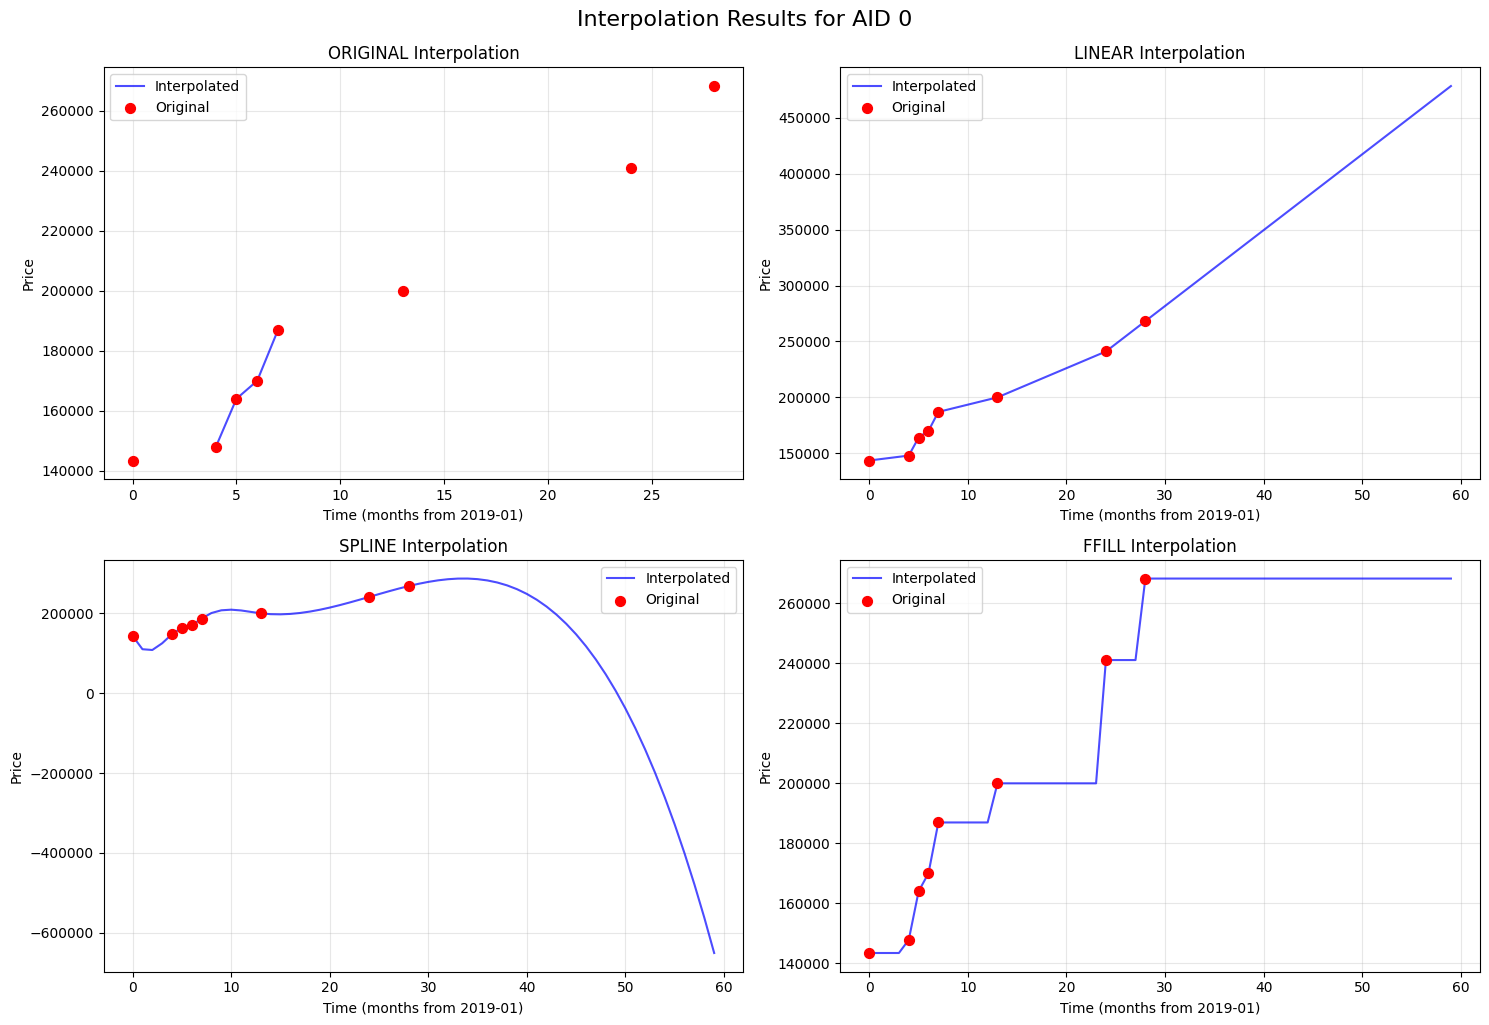


=== в│┤Ж░ёв▓Ћ Вё▒віЦ в╣ёЖхљ ===
Method          RMSE       MAE        Points  
---------------------------------------------
linear          0.0000     0.0000     8       
spline          0.0000     0.0000     8       
ffill           0.0000     0.0000     8       
bfill           0.0000     0.0000     8       


In [13]:
# ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВю╝вАю ьЁїВіцьіИ (Ж▓░ВИАВ╣ўЖ░ђ Въѕвіћ Ж▓йВџ░)
print("\n=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВю╝вАю в│┤Ж░ёв▓Ћ ьЁїВіцьіИ (AID 0) ===")

# aid=0ВЌљ вїђьЋ┤ ВЎёВаёьЋю вЇ░ВЮ┤ьё░ ВЃЮВё▒ ьЏё в│┤Ж░ёв▓Ћ ВаЂВџЕ
test_methods_quick = ['linear', 'spline', 'ffill', 'bfill']
results_complete = apply_interpolation_methods_complete(table_merge, aid_value=0, methods=test_methods_quick)

# Ж▓░Ж│╝ ьЎЋВЮИ
if results_complete:
    print("\n=== в│┤Ж░ё Ж▓░Ж│╝ ВџћВЋй ===")
    for method, data in results_complete.items():
        if data is not None:
            missing_count = data['price'].isna().sum()
            total_count = len(data)
            print(f"{method}: ВаёВ▓┤ {total_count}Ж░ю ВцЉ Ж▓░ВИАВ╣ў {missing_count}Ж░ю")
    
    # ВІюЖ░ЂьЎћ
    if len([k for k, v in results_complete.items() if v is not None]) > 1:
        plot_interpolation_results(results_complete, aid_value=0, max_methods=4)
        
    # Вё▒віЦ ьЈЅЖ░ђ
    if 'original' in results_complete:
        performance = evaluate_interpolation_performance(results_complete, results_complete['original'])
        
        if performance:
            print("\n=== в│┤Ж░ёв▓Ћ Вё▒віЦ в╣ёЖхљ ===")
            print(f"{'Method':<15} {'RMSE':<10} {'MAE':<10} {'Points':<8}")
            print("-" * 45)
            for method, metrics in performance.items():
                print(f"{method:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} {metrics['num_points']:<8}")
else:
    print("No results generated")

In [14]:
# ВаёВ▓┤ вЇ░ВЮ┤ьё░ВЌљ вїђьЋю ВЮ╝Ж┤ё В▓ўвдг ьЋеВѕў
def process_all_apartments(data, method='linear', save_results=True):
    """
    вфевЊа ВЋёьїїьіИВЌљ вїђьЋ┤ ВёаьЃЮвљю в│┤Ж░ёв▓ЋВЮё ВаЂВџЕ
    
    Args:
        data: ВаёВ▓┤ вЇ░ВЮ┤ьё░ьћёваѕВъё
        method: ВѓгВџЕьЋа в│┤Ж░ёв▓Ћ ('linear', 'polynomial', 'spline', 'ffill', 'bfill', 'nearest', 'gp', 'neural_ode')
        save_results: Ж▓░Ж│╝вЦ╝ ВађВъЦьЋаВДђ ВЌгвХђ
    
    Returns:
        pd.DataFrame: в│┤Ж░ёВЮ┤ ВЎёвБївљю вЇ░ВЮ┤ьё░ьћёваѕВъё
    """
    print(f"=== ВаёВ▓┤ ВЋёьїїьіИ {method} в│┤Ж░ё В▓ўвдг ВІюВъЉ ===")
    
    processed_data = []
    unique_aids = data['aid'].unique()
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if method not in method_functions:
        print(f"Unknown method: {method}")
        return data
    
    interpolation_func = method_functions[method]
    
    for i, aid in enumerate(unique_aids):
        if i % 100 == 0:
            print(f"Processing {i}/{len(unique_aids)} apartments...")
        
        try:
            apartment_data = prepare_time_series_data(data, aid)
            if len(apartment_data) > 0:
                interpolated_data = interpolation_func(apartment_data)
                processed_data.append(interpolated_data)
        except Exception as e:
            print(f"Error processing aid {aid}: {str(e)}")
            # ВЏљв│И вЇ░ВЮ┤ьё░ ЖиИвїђвАю ВХћЖ░ђ
            apartment_data = prepare_time_series_data(data, aid)
            if len(apartment_data) > 0:
                processed_data.append(apartment_data)
    
    # Ж▓░Ж│╝ ьЋЕВ╣ўЖИ░
    if processed_data:
        result_df = pd.concat(processed_data, ignore_index=True)
        
        # time_numeric В╗гвЪ╝ ВаюЖ▒░ (ВъёВІювАю вДївЊа Ж▓Ѓ)
        if 'time_numeric' in result_df.columns:
            result_df = result_df.drop('time_numeric', axis=1)
        
        print(f"В▓ўвдг ВЎёвБї!")
        print(f"ВЏљв│И Ж▓░ВИАВ╣ў: {data['price'].isna().sum()}")
        print(f"В▓ўвдг ьЏё Ж▓░ВИАВ╣ў: {result_df['price'].isna().sum()}")
        
        if save_results:
            filename = f'../вЇ░ВЮ┤ьё░/Table/table_merge_{method}_interpolated.csv'
            result_df.to_csv(filename, index=False)
            print(f"Ж▓░Ж│╝ ВађВъЦ: {filename}")
        
        return result_df
    else:
        print("No data processed")
        return data

# ВЌгвЪг в░Ев▓ЋВю╝вАю В▓ўвдгьЋўЖ│а в╣ёЖхљьЋўвіћ ьЋеВѕў
def compare_interpolation_methods_batch(data, methods=['linear', 'spline', 'gp'], sample_aids=None):
    """
    ВЌгвЪг в│┤Ж░ёв▓ЋВЮё ВЮ╝Ж┤ё ВаЂВџЕьЋўЖ│а Ж▓░Ж│╝ в╣ёЖхљ
    
    Args:
        data: ВаёВ▓┤ вЇ░ВЮ┤ьё░ьћёваѕВъё
        methods: в╣ёЖхљьЋа в░Ев▓ЋвЊцВЮў вдгВіцьіИ
        sample_aids: ВЃўьћївДЂьЋа ВЋёьїїьіИ IDвЊц (NoneВЮ┤вЕ┤ ВаёВ▓┤)
    """
    if sample_aids is None:
        # Ж▓░ВИАВ╣ўЖ░ђ Въѕвіћ ВЋёьїїьіИвЊц ВцЉ ВЮ╝вХђвДї ВЃўьћївДЂ
        aids_with_missing = data.groupby('aid')['price'].apply(lambda x: x.isna().any())
        sample_aids = aids_with_missing[aids_with_missing].index[:10].tolist()
    
    print(f"ВЃўьћї ВЋёьїїьіИвЊц: {sample_aids}")
    
    all_results = {}
    
    for method in methods:
        print(f"\n=== {method} в░Ев▓Ћ ВаЂВџЕ ВцЉ ===")
        method_results = {}
        
        for aid in sample_aids:
            try:
                apartment_data = prepare_time_series_data(data, aid)
                if len(apartment_data) > 0 and apartment_data['price'].isna().any():
                    
                    method_functions = {
                        'linear': linear_interpolation,
                        'polynomial': polynomial_interpolation,
                        'spline': spline_interpolation,
                        'ffill': forward_fill,
                        'bfill': backward_fill,
                        'nearest': nearest_neighbor_interpolation,
                        'gp': gaussian_process_interpolation,
                        'neural_ode': neural_ode_interpolation
                    }
                    
                    if method in method_functions:
                        result = method_functions[method](apartment_data)
                        method_results[aid] = result
            except Exception as e:
                print(f"Error processing aid {aid} with {method}: {str(e)}")
        
        all_results[method] = method_results
    
    return all_results

# ВЌЁвЇ░ВЮ┤ьіИвљю ВаёВ▓┤ вЇ░ВЮ┤ьё░ВЌљ вїђьЋю ВЮ╝Ж┤ё В▓ўвдг ьЋеВѕў
def process_all_apartments_complete(method='linear', save_results=True, sample_size=None):
    """
    вфевЊа ВЋёьїїьіИВЌљ вїђьЋ┤ ВЎёВаёьЋю ВІюЖ│ёВЌ┤ВЮё ВЃЮВё▒ьЋўЖ│а ВёаьЃЮвљю в│┤Ж░ёв▓ЋВЮё ВаЂВџЕ
    
    Args:
        method: ВѓгВџЕьЋа в│┤Ж░ёв▓Ћ ('linear', 'polynomial', 'spline', 'ffill', 'bfill', 'nearest', 'gp', 'neural_ode')
        save_results: Ж▓░Ж│╝вЦ╝ ВађВъЦьЋаВДђ ВЌгвХђ
        sample_size: ьЁїВіцьіИВџЕВю╝вАю В▓ўвдгьЋа ВЋёьїїьіИ Ж░юВѕў (NoneВЮ┤вЕ┤ ВаёВ▓┤)
    
    Returns:
        pd.DataFrame: в│┤Ж░ёВЮ┤ ВЎёвБївљю ВЎёВаёьЋю вЇ░ВЮ┤ьё░ьћёваѕВъё
    """
    print(f"=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВЌљВёю {method} в│┤Ж░ё В▓ўвдг ВІюВъЉ ===")
    
    # ве╝Вађ ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒
    print("1. ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ ВцЉ...")
    complete_dataset = create_complete_dataset(table_1, table_2, table_3)
    
    processed_data = []
    unique_aids = complete_dataset['aid'].unique()
    
    if sample_size is not None:
        unique_aids = unique_aids[:sample_size]
        print(f"ВЃўьћївДЂ: {len(unique_aids)}Ж░ю ВЋёьїїьіИвДї В▓ўвдг")
    
    method_functions = {
        'linear': linear_interpolation,
        'polynomial': polynomial_interpolation,
        'spline': spline_interpolation,
        'ffill': forward_fill,
        'bfill': backward_fill,
        'nearest': nearest_neighbor_interpolation,
        'gp': gaussian_process_interpolation,
        'neural_ode': neural_ode_interpolation
    }
    
    if method not in method_functions:
        print(f"Unknown method: {method}")
        return complete_dataset
    
    interpolation_func = method_functions[method]
    
    print("2. Ж░Ђ ВЋёьїїьіИв│ё в│┤Ж░ё В▓ўвдг ВцЉ...")
    for i, aid in enumerate(unique_aids):
        if i % 50 == 0:
            print(f"Processing {i}/{len(unique_aids)} apartments...")
        
        try:
            # ьЋ┤вІ╣ ВЋёьїїьіИ вЇ░ВЮ┤ьё░ ВХћВХю
            apartment_data = complete_dataset[complete_dataset['aid'] == aid].copy()
            apartment_data = apartment_data.sort_values(['year', 'month'])
            
            if len(apartment_data) > 0:
                # time_numeric ВХћЖ░ђ
                apartment_data['time_numeric'] = (apartment_data['year'] - 2019) * 12 + (apartment_data['month'] - 1)
                
                # в│┤Ж░ё ВаЂВџЕ
                interpolated_data = interpolation_func(apartment_data)
                
                # time_numeric В╗гвЪ╝ ВаюЖ▒░
                if 'time_numeric' in interpolated_data.columns:
                    interpolated_data = interpolated_data.drop('time_numeric', axis=1)
                
                processed_data.append(interpolated_data)
                
        except Exception as e:
            print(f"Error processing aid {aid}: {str(e)}")
            # ВЏљв│И вЇ░ВЮ┤ьё░ ЖиИвїђвАю ВХћЖ░ђ
            apartment_data = complete_dataset[complete_dataset['aid'] == aid].copy()
            if len(apartment_data) > 0:
                processed_data.append(apartment_data)
    
    # Ж▓░Ж│╝ ьЋЕВ╣ўЖИ░
    if processed_data:
        result_df = pd.concat(processed_data, ignore_index=True)
        result_df = result_df.sort_values(['aid', 'year', 'month']).reset_index(drop=True)
        
        print(f"В▓ўвдг ВЎёвБї!")
        print(f"ВЏљв│И Ж▓░ВИАВ╣ў: {complete_dataset['price'].isna().sum()}")
        print(f"В▓ўвдг ьЏё Ж▓░ВИАВ╣ў: {result_df['price'].isna().sum()}")
        print(f"В┤Ю ьќЅ Вѕў: {len(result_df)}")
        
        if save_results:
            filename = f'../вЇ░ВЮ┤ьё░/Table/complete_dataset_{method}_interpolated.csv'
            result_df.to_csv(filename, index=False)
            print(f"Ж▓░Ж│╝ ВађВъЦ: {filename}")
        
        return result_df
    else:
        print("No data processed")
        return complete_dataset

# ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВЌљВёю ВЌгвЪг в░Ев▓Ћ в╣ёЖхљ
def compare_interpolation_methods_complete(methods=['linear', 'spline'], sample_aids=None):
    """
    ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВЌљВёю ВЌгвЪг в│┤Ж░ёв▓ЋВЮё в╣ёЖхљ
    
    Args:
        methods: в╣ёЖхљьЋа в░Ев▓ЋвЊцВЮў вдгВіцьіИ
        sample_aids: ВЃўьћївДЂьЋа ВЋёьїїьіИ IDвЊц (NoneВЮ┤вЕ┤ Ж▓░ВИАВ╣ўЖ░ђ Въѕвіћ В▓ўВЮї 5Ж░ю)
    """
    if sample_aids is None:
        # ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ьЋўЖ│а Ж▓░ВИАВ╣ўЖ░ђ Въѕвіћ ВЋёьїїьіИвЊц В░ЙЖИ░
        complete_dataset = create_complete_dataset(table_1, table_2, table_3)
        aids_with_missing = complete_dataset.groupby('aid')['price'].apply(lambda x: x.isna().any())
        sample_aids = aids_with_missing[aids_with_missing].index[:5].tolist()
    
    print(f"ВЃўьћї ВЋёьїїьіИвЊц: {sample_aids}")
    
    all_results = {}
    
    for method in methods:
        print(f"\n=== {method} в░Ев▓Ћ ВаЂВџЕ ВцЉ ===")
        method_results = {}
        
        for aid in sample_aids:
            try:
                result = apply_interpolation_methods_complete(aid, methods=[method])
                if method in result and result[method] is not None:
                    method_results[aid] = result[method]
            except Exception as e:
                print(f"Error processing aid {aid} with {method}: {str(e)}")
        
        all_results[method] = method_results
    
    return all_results

=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВЮё ВѓгВџЕьЋю в│┤Ж░ёв▓Ћ ВўѕВІю ===

1. ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ ьЁїВіцьіИ (В▓ўВЮї 5Ж░ю ВЋёьїїьіИвДї)

2. aid=0ВЌљ вїђьЋю ВЎёВаёьЋю в│┤Ж░ёв▓Ћ ВаЂВџЕ

=== AID 0 ВЎёВаёьЋю вЇ░ВЮ┤ьё░ в│┤Ж░ё Ж▓░Ж│╝ ===
ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: 60
Ж▓░ВИАВ╣ў Ж░юВѕў: 52
вЇ░ВЮ┤ьё░Ж░ђ Въѕвіћ ьЈгВЮИьіИ: 8

ВаЂВџЕ ВцЉ: linear
linear ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: spline
spline ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: ffill
ffill ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 0

ВаЂВџЕ ВцЉ: bfill
bfill ВЎёвБї - вѓеВЮђ Ж▓░ВИАВ╣ў: 31

3. Ж▓░Ж│╝ ВІюЖ░ЂьЎћ


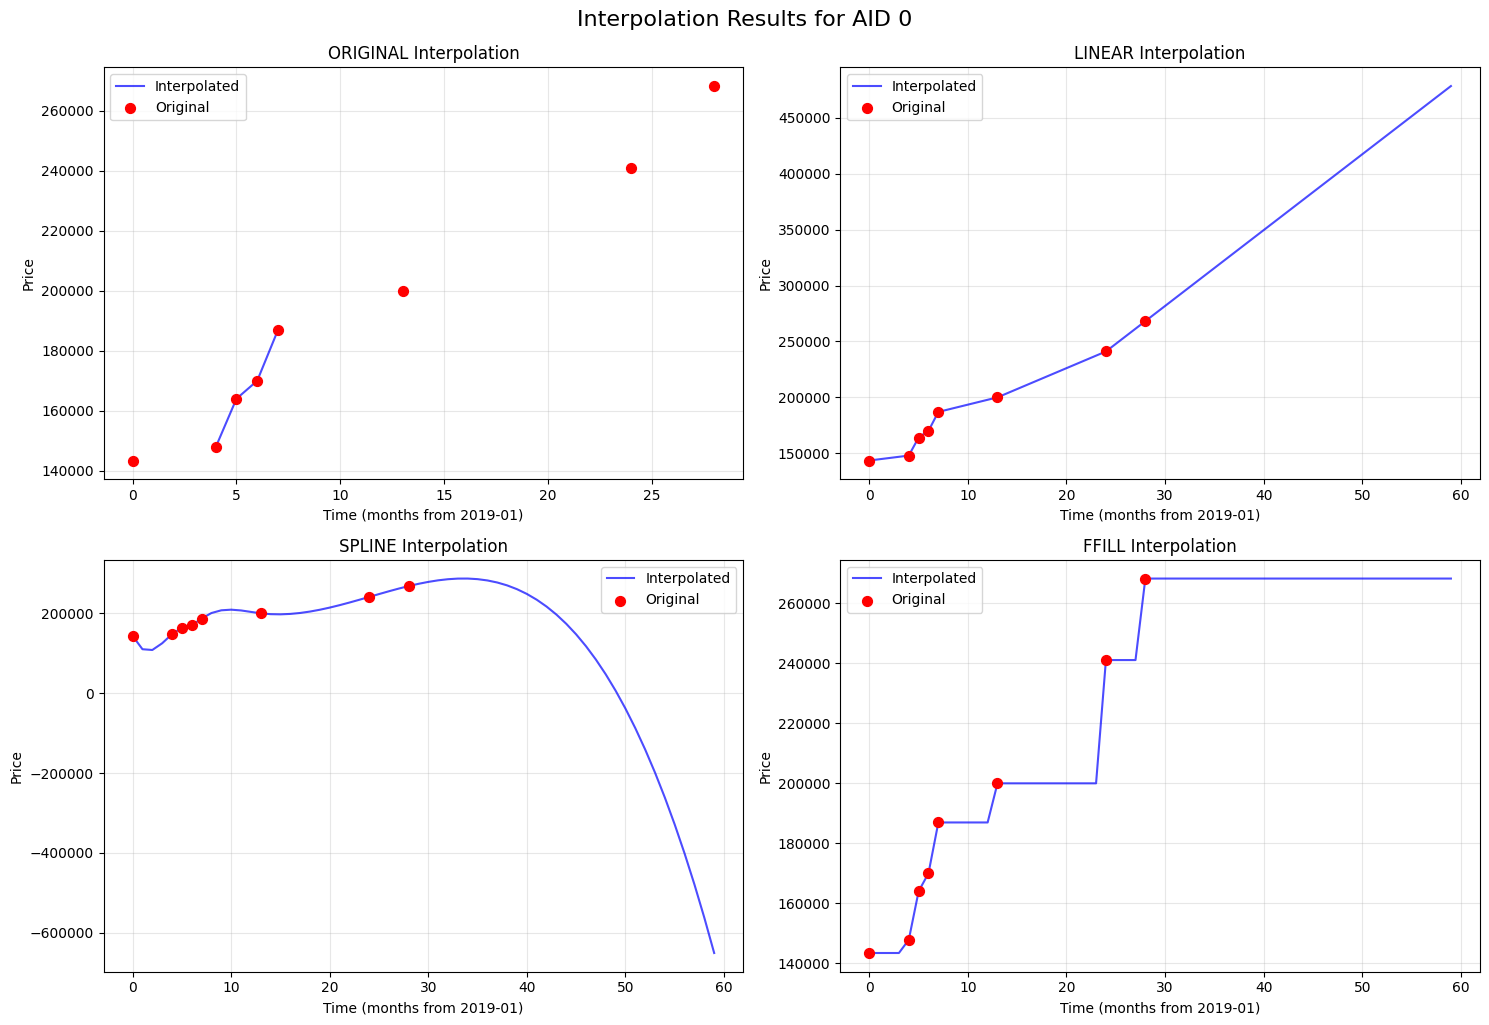


4. Вё▒віЦ ьЈЅЖ░ђ
Method          RMSE       MAE        Points  
---------------------------------------------
linear          0.0000     0.0000     8       
spline          0.0000     0.0000     8       
ffill           0.0000     0.0000     8       
bfill           0.0000     0.0000     8       

=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВѓгВџЕв▓Ћ ВЋѕвѓ┤ ===
1. Ж░юв│ё ВЋёьїїьіИ В▓ўвдг:
   apply_interpolation_methods_complete(table_merge, aid_value=0, methods=['linear'])

2. ВаёВ▓┤ вЇ░ВЮ┤ьё░ В▓ўвдг:
   process_all_apartments_complete(method='linear', sample_size=10)

3. ВЌгвЪг в░Ев▓Ћ в╣ёЖхљ:
   compare_interpolation_methods_complete(methods=['linear', 'spline'])

ВБ╝ВЮў: ВаёВ▓┤ вЇ░ВЮ┤ьё░ В▓ўвдгвіћ ВІюЖ░ёВЮ┤ Вўцвъў Ж▒Ивд┤ Вѕў ВъѕВю╝вІѕ ве╝Вађ sample_sizeвЦ╝ ВъЉЖ▓ї ВёцВаЋьЋ┤Вёю ьЁїВіцьіИьЋўВёИВџћ!


In [15]:
# ВЌЁвЇ░ВЮ┤ьіИвљю ВѓгВџЕ ВўѕВІювЊц

print("=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІВЮё ВѓгВџЕьЋю в│┤Ж░ёв▓Ћ ВўѕВІю ===")

# 1. ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ (ВЃўьћї)
print("\n1. ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ ьЁїВіцьіИ (В▓ўВЮї 5Ж░ю ВЋёьїїьіИвДї)")
# sample_complete_dataset = process_all_apartments_complete(method='linear', save_results=False, sample_size=5)

# 2. ьі╣ВаЋ ВЋёьїїьіИВЌљ вїђьЋю ВЎёВаёьЋю в│┤Ж░ёв▓Ћ ВаЂВџЕ
print("\n2. aid=0ВЌљ вїђьЋю ВЎёВаёьЋю в│┤Ж░ёв▓Ћ ВаЂВџЕ")
complete_results = apply_interpolation_methods_complete(
    table_merge,
    aid_value=0, 
    methods=['linear', 'spline', 'ffill', 'bfill']  # в╣авЦИ в░Ев▓ЋвЊцвДї
)

# 3. Ж▓░Ж│╝ ВІюЖ░ЂьЎћ
if complete_results and len([k for k, v in complete_results.items() if v is not None]) > 1:
    print("\n3. Ж▓░Ж│╝ ВІюЖ░ЂьЎћ")
    plot_interpolation_results(complete_results, 0)

# 4. Вё▒віЦ ьЈЅЖ░ђ
if complete_results and 'original' in complete_results:
    print("\n4. Вё▒віЦ ьЈЅЖ░ђ")
    performance = evaluate_interpolation_performance(complete_results, complete_results['original'])
    
    if performance:
        print(f"{'Method':<15} {'RMSE':<10} {'MAE':<10} {'Points':<8}")
        print("-" * 45)
        for method, metrics in performance.items():
            print(f"{method:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} {metrics['num_points']:<8}")

print("\n=== ВЎёВаёьЋю вЇ░ВЮ┤ьё░ВЁІ ВѓгВџЕв▓Ћ ВЋѕвѓ┤ ===")
print("1. Ж░юв│ё ВЋёьїїьіИ В▓ўвдг:")
print("   apply_interpolation_methods_complete(table_merge, aid_value=0, methods=['linear'])")
print("\n2. ВаёВ▓┤ вЇ░ВЮ┤ьё░ В▓ўвдг:")
print("   process_all_apartments_complete(method='linear', sample_size=10)")
print("\n3. ВЌгвЪг в░Ев▓Ћ в╣ёЖхљ:")
print("   compare_interpolation_methods_complete(methods=['linear', 'spline'])")
print("\nВБ╝ВЮў: ВаёВ▓┤ вЇ░ВЮ┤ьё░ В▓ўвдгвіћ ВІюЖ░ёВЮ┤ Вўцвъў Ж▒Ивд┤ Вѕў ВъѕВю╝вІѕ ве╝Вађ sample_sizeвЦ╝ ВъЉЖ▓ї ВёцВаЋьЋ┤Вёю ьЁїВіцьіИьЋўВёИВџћ!")

## ВёцВ╣ў ьЋёВџћьЋю ьїеьѓцВДђ

Neural ODEвЦ╝ ВѓгВџЕьЋўвацвЕ┤ вІцВЮї ьїеьѓцВДђвЦ╝ ВёцВ╣ўьЋ┤ВЋ╝ ьЋЕвІѕвІц:

```bash
pip install torchdiffeq
```

## в│┤Ж░ёв▓Ћ ВёцвфЁ

1. **ВёаьўЋ в│┤Ж░ёв▓Ћ (Linear Interpolation)**: Ж░ђВъЦ вІеВѕюьЋўЖ│а в╣авЦИ в░Ев▓Ћ. вЉљ Ваљ ВѓгВЮ┤вЦ╝ ВДЂВёаВю╝вАю ВЌ░Ж▓░
2. **вІцьЋГ в│┤Ж░ёв▓Ћ (Polynomial Interpolation)**: вЮ╝ЖиИвъЉВБ╝ вІцьЋГВІЮВЮё ВѓгВџЕ. вЇ░ВЮ┤ьё░ ьЈгВЮИьіИЖ░ђ вДјВю╝вЕ┤ вХѕВЋѕВаЋьЋа Вѕў ВъѕВЮї
3. **ВіцьћївЮ╝ВЮИ в│┤Ж░ёв▓Ћ (Spline Interpolation)**: ьЂљв╣Ё ВіцьћївЮ╝ВЮИВю╝вАю вХђвЊювЪгВџ┤ Ж│АВёа ВЃЮВё▒
4. **Forward Fill (ffill)**: ВЋъВЮў Ж░њВю╝вАю В▒ёВџ░ЖИ░
5. **Backward Fill (bfill)**: вњцВЮў Ж░њВю╝вАю В▒ёВџ░ЖИ░  
6. **ВхюЖи╝ВаЉ ВЮ┤ВЏЃ в│┤Ж░ёв▓Ћ**: Ж░ђВъЦ Ж░ђЖ╣їВџ┤ ВІюВаљВЮў Ж░њВю╝вАю В▒ёВџ░ЖИ░
7. **Ж░ђВџ░ВІюВЋѕ ьћёвАюВёИВіц (GP)**: ьЎЋвЦаВаЂ ВаЉЖи╝, вХѕьЎЋВІцВё▒вЈё ьЋеЖ╗ў ВаюЖ│х
8. **Neural ODE**: ВІаЖ▓йвДЮ ЖИ░в░ў в»ИвХёв░ЕВаЋВІЮВю╝вАю ВЌ░ВєЇВаЂВЮИ dynamics ьЋЎВіх

## ВѓгВџЕ ЖХїВъЦВѓгьЋГ

- **в╣авЦИ В▓ўвдгЖ░ђ ьЋёВџћьЋю Ж▓йВџ░**: linear, ffill, bfill
- **вХђвЊювЪгВџ┤ Ж│АВёаВЮ┤ ьЋёВџћьЋю Ж▓йВџ░**: spline, gp
- **в│хВъАьЋю ьїеьё┤ВЮ┤ Въѕвіћ Ж▓йВџ░**: neural_ode, gp
- **Ж▓░ВИАВ╣ўЖ░ђ ВЌ░ВєЇВаЂВю╝вАю вДјВЮђ Ж▓йВџ░**: polynomial, spline (вІе, В░еВѕў ВА░Ваѕ ьЋёВџћ)

### Embedding

In [22]:
epochs = 10000
lr = 1e-4
hidden_dim = 1024
sub = True # True
embedding_dim = 1024 # 1024
window_size = 12 # 12

In [23]:
# ьїївЮ╝в»Иьё░
embedding_train_ratio = 0.7
embedding_val_ratio = 0.0
embedding_test_ratio = 0.3
embedding_batch = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_lr = 0.00001
embedding_weight_decay = 0
embedding_batch = 128
embedding_epochs = 150
encoder_dim_1 = 128
encoder_dim_2 = 256
encoder_dim_3 = 512
embedding_dim = 1024
decoder_dim_1 = 512
decoder_dim_2 = 256
decoder_dim_3 = 128

embedding_window_size = 12 #????

=== Embedding ьЏѕвае ВІюВъЉ ===
ьЏѕваеВџЕ ьїїВЮ╝ Вѕў: 8
ьЁїВіцьіИ ьїїВЮ╝: ../вЇ░ВЮ┤ьё░/MissingValue\table_merge_2023.xlsx
ьЁїВіцьіИ вЇ░ВЮ┤ьё░ вАювЊю: ../вЇ░ВЮ┤ьё░/MissingValue\table_merge_2023.xlsx
ьЁїВіцьіИ вЇ░ВЮ┤ьё░ ьЂгЖИ░: (2569, 19)
ьЁїВіцьіИ вЇ░ВЮ┤ьё░ Ж▓░ВИАВ╣ў: 0
РюЁ ьЁїВіцьіИ вЇ░ВЮ┤ьё░ВЁІ ьЂгЖИ░: 2569

­Ъћё [1/8] bfill в░Ев▓ЋВю╝вАю Embedding ьЏѕвае
ьїїВЮ╝: ../вЇ░ВЮ┤ьё░/MissingValue\bfill_2021.xlsx
ьЁїВіцьіИ вЇ░ВЮ┤ьё░ ьЂгЖИ░: (2569, 19)
ьЁїВіцьіИ вЇ░ВЮ┤ьё░ Ж▓░ВИАВ╣ў: 0
РюЁ ьЁїВіцьіИ вЇ░ВЮ┤ьё░ВЁІ ьЂгЖИ░: 2569

­Ъћё [1/8] bfill в░Ев▓ЋВю╝вАю Embedding ьЏѕвае
ьїїВЮ╝: ../вЇ░ВЮ┤ьё░/MissingValue\bfill_2021.xlsx
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 4713
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 4713
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
­Ъџђ bfill ьЏѕвае ВІюВъЉ...
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ


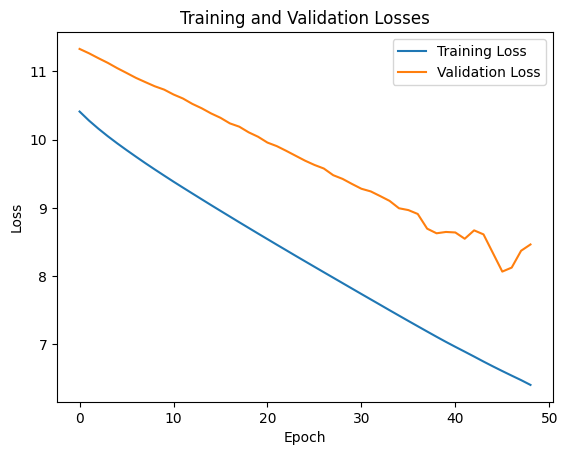


­Ъћё [5/8] nearest в░Ев▓ЋВю╝вАю Embedding ьЏѕвае
ьїїВЮ╝: ../вЇ░ВЮ┤ьё░/MissingValue\nearest_2021.xlsx
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 1188
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
­Ъџђ nearest ьЏѕвае ВІюВъЉ...
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 1188
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
­Ъџђ nearest ьЏѕвае ВІюВъЉ...
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch

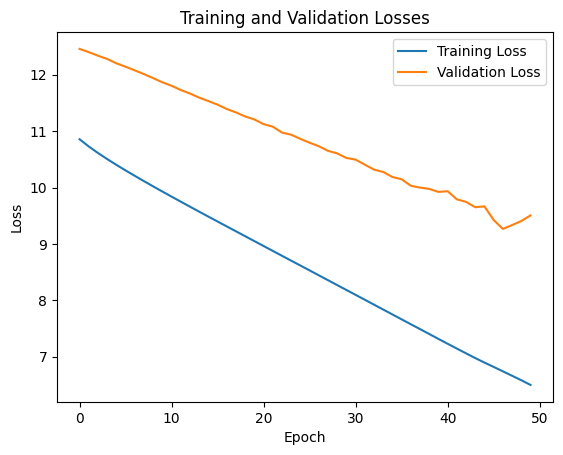


­Ъћё [6/8] polynomial в░Ев▓ЋВю╝вАю Embedding ьЏѕвае
ьїїВЮ╝: ../вЇ░ВЮ┤ьё░/MissingValue\polynomial_2021.xlsx
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 1888
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
­Ъџђ polynomial ьЏѕвае ВІюВъЉ...
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 1888
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
­Ъџђ polynomial ьЏѕвае ВІюВъЉ...
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ



­Ъћё [7/8] spline в░Ев▓ЋВю╝вАю Embedding ьЏѕвае
ьїїВЮ╝: ../вЇ░ВЮ┤ьё░/MissingValue\spline_2021.xlsx
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 1888
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
­Ъџђ spline ьЏѕвае ВІюВъЉ...
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (25236, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 1888
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 17665, Ж▓ђВдЮ: 7571
­Ъџђ spline ьЏѕвае ВІюВъЉ...
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ
Рџа№ИЈ Epoch 1: 


­Ъћё [8/8] table_merge в░Ев▓ЋВю╝вАю Embedding ьЏѕвае
ьїїВЮ╝: ../вЇ░ВЮ┤ьё░/MissingValue\table_merge_2021.xlsx
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (57800, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 0
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 40460, Ж▓ђВдЮ: 17340
­Ъџђ table_merge ьЏѕвае ВІюВъЉ...
ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: (57800, 19)
Ж▓░ВИАВ╣ў Ж░юВѕў: 0
РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: 40460, Ж▓ђВдЮ: 17340
­Ъџђ table_merge ьЏѕвае ВІюВъЉ...
Epoch [1/150], Train Loss: 4.961905, Val Loss: 9.034721
Epoch [1/150], Train Loss: 4.961905, Val Loss: 9.034721
Epoch [10/150], Train Loss: 2.757991, Val Loss: 7.366921
Epoch [10/150], Train Loss: 2.757991, Val Loss: 7.366921
Epoch [20/150], Train Loss: 1.075812, Val Loss: 5.832965
Epoch [20/150], Train Loss: 1.075812, Val Loss: 5.832965
Epoch [30/150], Train Loss: 0.534790, Val Loss: 4.992555
Epoch [30/150], Train Loss: 0.534790, Val Loss: 4.992555
Epoch [40/150], Train Loss: 0.483615, Val Loss: 4.808389
Epoch [40/150], Train Loss: 0.483615, Val Loss: 4.808389
Epoch [50/150], Train 


­ЪЊІ ВаёВ▓┤ Ж▓░Ж│╝ ВаЋвдг

­ЪЈє Embedding Ж▓░Ж│╝ ВџћВЋй (Val Loss ЖИ░Вцђ ВаЋваг):
     Method  Best_Epoch  Best_Val_Loss  Test_Loss
table_merge          70   4.541987e+00   9.303299
     linear          47   8.066902e+00   6.658679
    nearest          48   9.266335e+00   7.490625
     spline          46   4.205887e+01  10.336520
 polynomial          90   1.087557e+11  13.948372

­ЪњЙ Ж▓░Ж│╝ ВађВъЦвље: ../вЇ░ВЮ┤ьё░/MissingValue/embedding_results_summary.xlsx

­Ъј» ВхюЖ│а Вё▒віЦ в░Ев▓Ћ: table_merge
   ­ЪЊѕ Best Epoch: 70
   ­ЪЊі Best Val Loss: 4.541987
   ­Ъј» Test Loss: 9.303299

­ЪјЅ вфевЊа Embedding В▓ўвдг ВЎёвБї!


In [24]:
# MissingValue ьЈ┤вЇћВЮў вфевЊа в│┤Ж░ё вЇ░ВЮ┤ьё░вАю Embedding ьЏѕвае в░Ј ьЈЅЖ░ђ
import os
import glob
import pandas as pd
import copy
import numpy as np

# Ж▓░Ж│╝вЦ╝ ВађВъЦьЋа вдгВіцьіИ
embedding_results = []

# MissingValue ьЈ┤вЇћВЌљВёю ьЏѕваеВџЕ ьїїВЮ╝вЊц В░ЙЖИ░ (2021 вЇ░ВЮ┤ьё░)
missing_value_dir = "../вЇ░ВЮ┤ьё░/MissingValue"
train_files = glob.glob(os.path.join(missing_value_dir, "*_2021.xlsx"))
test_file = os.path.join(missing_value_dir, "table_merge_2023.xlsx")

print(f"=== Embedding ьЏѕвае ВІюВъЉ ===")
print(f"ьЏѕваеВџЕ ьїїВЮ╝ Вѕў: {len(train_files)}")
print(f"ьЁїВіцьіИ ьїїВЮ╝: {test_file}")

# ьЁїВіцьіИ вЇ░ВЮ┤ьё░ вАювЊю (ьЋю в▓ѕвДї)
test_dataloader = None
if os.path.exists(test_file):
    print(f"ьЁїВіцьіИ вЇ░ВЮ┤ьё░ вАювЊю: {test_file}")
    test_data = pd.read_excel(test_file)
    print(f"ьЁїВіцьіИ вЇ░ВЮ┤ьё░ ьЂгЖИ░: {test_data.shape}")
    print(f"ьЁїВіцьіИ вЇ░ВЮ┤ьё░ Ж▓░ВИАВ╣ў: {test_data['price'].isna().sum()}")
    
    # ьЁїВіцьіИ вЇ░ВЮ┤ьё░ Ж▓ђВдЮ
    if test_data['price'].isna().all():
        print("Рџа№ИЈ ьЁїВіцьіИ вЇ░ВЮ┤ьё░ВЮў вфевЊа priceЖ░ђ Ж▓░ВИАВ╣ўВъЁвІѕвІц.")
        test_dataloader = None
    else:
        try:
            # ьЁїВіцьіИ вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒
            test_dataset = Embedding_Dataset(test_data, DEVICE)
            if len(test_dataset) > 0:
                test_dataloader = DataLoader(test_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
                print(f"РюЁ ьЁїВіцьіИ вЇ░ВЮ┤ьё░ВЁІ ьЂгЖИ░: {len(test_dataset)}")
            else:
                test_dataloader = None
                print("РЮї ьЁїВіцьіИ вЇ░ВЮ┤ьё░ВЁІВЮ┤ в╣ёВќ┤ВъѕВЮї")
        except Exception as e:
            print(f"РЮї ьЁїВіцьіИ вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒ ВІцьїе: {str(e)}")
            test_dataloader = None
else:
    print(f"РЮї ьЁїВіцьіИ ьїїВЮ╝ВЮ┤ ВЌєВіхвІѕвІц: {test_file}")

# Ж░Ђ ьЏѕвае ьїїВЮ╝ВЌљ вїђьЋ┤ embedding ВѕўьќЅ
for file_idx, train_file in enumerate(train_files):
    # ьїїВЮ╝вфЁВЌљВёю в░Ев▓Ћ ВХћВХю
    method_name = os.path.basename(train_file).replace("_2021.xlsx", "")
    print(f"\n{'='*60}")
    print(f"­Ъћё [{file_idx+1}/{len(train_files)}] {method_name} в░Ев▓ЋВю╝вАю Embedding ьЏѕвае")
    print(f"ьїїВЮ╝: {train_file}")
    print(f"{'='*60}")
    
    try:
        # ьЏѕвае вЇ░ВЮ┤ьё░ вАювЊю
        table_merge = pd.read_excel(train_file, engine='openpyxl')
        print(f"ьЏѕвае вЇ░ВЮ┤ьё░ ьЂгЖИ░: {table_merge.shape}")
        print(f"Ж▓░ВИАВ╣ў Ж░юВѕў: {table_merge['price'].isna().sum()}")
        
        # вЇ░ВЮ┤ьё░ Ж▓ђВдЮ
        if table_merge.empty:
            print(f"РЮї {method_name}: вЇ░ВЮ┤ьё░Ж░ђ в╣ёВќ┤ВъѕВЮї")
            continue
            
        if table_merge['price'].isna().all():
            print(f"РЮї {method_name}: вфевЊа priceЖ░ђ Ж▓░ВИАВ╣ў")
            continue
        
        # вг┤ьЋюЖ░њВЮ┤вѓў в╣ёВаЋВЃЂВаЂВЮИ Ж░њ В▓┤ьЂг
        if np.isinf(table_merge['price']).any():
            print(f"Рџа№ИЈ {method_name}: priceВЌљ вг┤ьЋюЖ░њ в░юЖ▓г, ВаюЖ▒░ ВцЉ...")
            table_merge = table_merge[~np.isinf(table_merge['price'])]
            
        if np.isnan(table_merge['price']).all():
            print(f"РЮї {method_name}: вг┤ьЋюЖ░њ ВаюЖ▒░ ьЏё вфевЊа вЇ░ВЮ┤ьё░Ж░ђ Ж▓░ВИАВ╣ў")
            continue
        
        # вЇ░ВЮ┤ьё░ВЁІ ВЃЮВё▒
        dataset = Embedding_Dataset(table_merge, DEVICE)
        
        if len(dataset) == 0:
            print(f"РЮї {method_name}: вЇ░ВЮ┤ьё░ВЁІВЮ┤ в╣ёВќ┤ВъѕВЮї")
            continue
            
        dataset_length = len(dataset)
        split_point = int(embedding_train_ratio * len(dataset))
        
        if split_point == 0 or split_point == dataset_length:
            print(f"РЮї {method_name}: вЇ░ВЮ┤ьё░ вХёьЋа ВўцвЦў (split_point: {split_point}, total: {dataset_length})")
            continue
            
        train_indices = range(0, split_point)
        val_indices = range(split_point, dataset_length)

        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        
        if len(train_dataloader) == 0 or len(val_dataloader) == 0:
            print(f"РЮї {method_name}: DataLoaderЖ░ђ в╣ёВќ┤ВъѕВЮї (train: {len(train_dataloader)}, val: {len(val_dataloader)})")
            continue
        
        print(f"РюЁ вЇ░ВЮ┤ьё░ Вцђв╣ё ВЎёвБї - ьЏѕвае: {len(train_dataset)}, Ж▓ђВдЮ: {len(val_dataset)}")
        
        # вфевЇИ В┤ѕЖИ░ьЎћ
        model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                         decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
        criterion = RMSE()
        optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_epoch = 0
        best_model_state = None
        consecutive_val_loss_increases = 0
        max_consecutive_val_loss_increases = 3

        print(f"­Ъџђ {method_name} ьЏѕвае ВІюВъЉ...")
        
        for epoch in range(embedding_epochs):
            # ьЏѕвае вІеЖ│ё
            model.train()
            total_train_loss = 0
            train_batch_count = 0
            
            for data in train_dataloader:
                input = data[0].to(DEVICE)
                target = data[1].to(DEVICE)
                
                # ВъЁваЦ вЇ░ВЮ┤ьё░ Ж▓ђВдЮ
                if torch.isnan(input).any() or torch.isinf(input).any():
                    print(f"Рџа№ИЈ Epoch {epoch+1}: ьЏѕвае ВъЁваЦВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ")
                    continue
                if torch.isnan(target).any() or torch.isinf(target).any():
                    print(f"Рџа№ИЈ Epoch {epoch+1}: ьЏѕвае ьЃђЖ▓ЪВЌљ NaN/Inf в░юЖ▓г, Ж▒┤вёѕвюђ")
                    continue
                
                output = model(input).to(DEVICE)
                
                # ВХюваЦ Ж▓ђВдЮ
                if torch.isnan(output).any() or torch.isinf(output).any():
                    print(f"Рџа№ИЈ Epoch {epoch+1}: вфевЇИ ВХюваЦВЌљ NaN/Inf в░юЖ▓г")
                    break

                train_loss = criterion(output, target)
                
                # Loss Ж▓ђВдЮ
                if torch.isnan(train_loss) or torch.isinf(train_loss):
                    print(f"Рџа№ИЈ Epoch {epoch+1}: ьЏѕвае lossЖ░ђ NaN/Inf")
                    break
                
                total_train_loss += train_loss.item()
                train_batch_count += 1

                optimizer.zero_grad()
                train_loss.backward()
                
                # ЖиИвъўвћћВќИьіИ ьЂ┤вдгьЋЉ
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()

            if train_batch_count == 0:
                print(f"РЮї Epoch {epoch+1}: ВюаьџеьЋю ьЏѕвае в░░В╣ўЖ░ђ ВЌєВЮї")
                break
                
            avg_train_loss = total_train_loss / train_batch_count
            
            if np.isnan(avg_train_loss) or np.isinf(avg_train_loss):
                print(f"РЮї Epoch {epoch+1}: ьЈЅЖиа ьЏѕвае lossЖ░ђ NaN/Inf ({avg_train_loss})")
                break
                
            train_losses.append(avg_train_loss)

            # Ж▓ђВдЮ вІеЖ│ё
            model.eval()
            total_val_loss = 0
            val_batch_count = 0
            
            with torch.no_grad():
                for data in val_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    
                    # ВъЁваЦ вЇ░ВЮ┤ьё░ Ж▓ђВдЮ
                    if torch.isnan(input).any() or torch.isinf(input).any():
                        continue
                    if torch.isnan(target).any() or torch.isinf(target).any():
                        continue
                    
                    output = model(input).to(DEVICE)
                    
                    if torch.isnan(output).any() or torch.isinf(output).any():
                        continue

                    val_loss = criterion(output, target)
                    
                    if torch.isnan(val_loss) or torch.isinf(val_loss):
                        continue
                        
                    total_val_loss += val_loss.item()
                    val_batch_count += 1

            if val_batch_count == 0:
                print(f"РЮї Epoch {epoch+1}: ВюаьџеьЋю Ж▓ђВдЮ в░░В╣ўЖ░ђ ВЌєВЮї")
                break
                
            avg_val_loss = total_val_loss / val_batch_count
            
            if np.isnan(avg_val_loss) or np.isinf(avg_val_loss):
                print(f"РЮї Epoch {epoch+1}: ьЈЅЖиа Ж▓ђВдЮ lossЖ░ђ NaN/Inf ({avg_val_loss})")
                break
                
            val_losses.append(avg_val_loss)
            
            # ВхюЖ│а Вё▒віЦ ЖИ░вАЮ
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                best_model_state = copy.deepcopy(model.state_dict())

            early_stop, consecutive_val_loss_increases = early_stops(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
            
            if early_stop:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
                print(f'РюІ Early Stop Triggered!')
                break

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if not train_losses or not val_losses:
            print(f"РЮї {method_name}: ьЏѕваеВЮ┤ ВаювїђвАю ВДёьќЅвљўВДђ ВЋіВЮї")
            continue
            
        print(f"РюЁ {method_name} ьЏѕвае ВЎёвБї!")
        print(f"   Best Epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")
        
        # ВхюЖ│а вфевЇИвАю ьЁїВіцьіИ вЇ░ВЮ┤ьё░ ьЈЅЖ░ђ
        avg_test_loss = float('nan')
        if test_dataloader is not None and best_model_state is not None:
            print(f"­ЪЊі {method_name} ьЁїВіцьіИ вЇ░ВЮ┤ьё░ ьЈЅЖ░ђ ВцЉ...")
            
            try:
                # ВхюЖ│а вфевЇИ вАювЊю
                model.load_state_dict(best_model_state)
                
                model.eval()
                total_test_loss = 0
                test_batch_count = 0
                
                with torch.no_grad():
                    for data in test_dataloader:
                        input = data[0].to(DEVICE)
                        target = data[1].to(DEVICE)
                        
                        if torch.isnan(input).any() or torch.isinf(input).any():
                            continue
                        if torch.isnan(target).any() or torch.isinf(target).any():
                            continue
                        
                        output = model(input).to(DEVICE)
                        
                        if torch.isnan(output).any() or torch.isinf(output).any():
                            continue

                        test_loss = criterion(output, target)
                        
                        if torch.isnan(test_loss) or torch.isinf(test_loss):
                            continue
                            
                        total_test_loss += test_loss.item()
                        test_batch_count += 1

                if test_batch_count > 0:
                    avg_test_loss = total_test_loss / test_batch_count
                    print(f"   Test Loss: {avg_test_loss:.6f}")
                else:
                    print(f"   Рџа№ИЈ ВюаьџеьЋю ьЁїВіцьіИ в░░В╣ўЖ░ђ ВЌєВЮї")
                    
            except Exception as e:
                print(f"   РЮї ьЁїВіцьіИ ьЈЅЖ░ђ ВІцьїе: {str(e)}")
        
        # ВхюЖ│а вфевЇИ ВађВъЦ
        if best_model_state is not None:
            model_save_path = f'../вЇ░ВЮ┤ьё░/Checkpoint/embedding/default/{method_name}_best_model.pth'
            torch.save(best_model_state, model_save_path)
            print(f"   ­ЪњЙ вфевЇИ ВађВъЦ: {model_save_path}")
        
        # Ж▓░Ж│╝ ВађВъЦ
        result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': best_epoch,
            'Best_Val_Loss': round(best_val_loss, 6) if not (np.isnan(best_val_loss) or np.isinf(best_val_loss)) else 'Invalid',
            'Final_Train_Loss': round(train_losses[-1], 6) if train_losses and not (np.isnan(train_losses[-1]) or np.isinf(train_losses[-1])) else 'Invalid',
            'Test_Loss': round(avg_test_loss, 6) if not (pd.isna(avg_test_loss) or np.isinf(avg_test_loss)) else 'N/A',
            'Total_Epochs': len(train_losses),
            'Train_Data_Size': len(train_dataset),
            'Val_Data_Size': len(val_dataset),
            'Test_Data_Size': len(test_dataset) if test_dataloader is not None else 0
        }
        
        embedding_results.append(result)
        
        # ВЮ┤ в░Ев▓ЋВЮў ЖиИвъўьћё ЖиИвдгЖИ░
        if train_losses and val_losses:
            try:
                print(f"­ЪЊі {method_name} ьЋЎВіх Ж│АВёа ЖиИвъўьћё ВЃЮВё▒")
                plot_train_val_losses(train_losses, val_losses)
            except Exception as e:
                print(f"Рџа№ИЈ ЖиИвъўьћё ВЃЮВё▒ ВІцьїе: {str(e)}")
        
    except Exception as e:
        print(f"РЮї {method_name} В▓ўвдг ВцЉ ВўцвЦў: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # ВўцвЦў Ж▓░Ж│╝вЈё ЖИ░вАЮ
        error_result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': 'Error',
            'Best_Val_Loss': 'Error', 
            'Final_Train_Loss': 'Error',
            'Test_Loss': 'Error',
            'Total_Epochs': 'Error',
            'Train_Data_Size': 'Error',
            'Val_Data_Size': 'Error',
            'Test_Data_Size': 'Error'
        }
        embedding_results.append(error_result)
            
        dataset_length = len(dataset)
        split_point = int(embedding_train_ratio * len(dataset))
        train_indices = range(0, split_point)
        val_indices = range(split_point, dataset_length)

        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        
        print(f"ьЏѕвае вЇ░ВЮ┤ьё░: {len(train_dataset)}, Ж▓ђВдЮ вЇ░ВЮ┤ьё░: {len(val_dataset)}")
        
        # вфевЇИ В┤ѕЖИ░ьЎћ
        model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                         decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
        criterion = RMSE()
        optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_epoch = 0
        best_model_state = None
        consecutive_val_loss_increases = 0
        max_consecutive_val_loss_increases = 3

        print(f"­Ъџђ {method_name} ьЏѕвае ВІюВъЉ...")
        
        for epoch in range(embedding_epochs):
            model.train()
            total_train_loss = 0
            for data in train_dataloader:
                input = data[0].to(DEVICE)
                target = data[1].to(DEVICE)
                output = model(input).to(DEVICE)

                train_loss = criterion(output, target)
                total_train_loss += train_loss.item()

                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

            avg_train_loss = total_train_loss / len(train_dataloader)
            train_losses.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for data in val_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    output = model(input).to(DEVICE)

                    val_loss = criterion(output, target)
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)
            
            # ВхюЖ│а Вё▒віЦ ЖИ░вАЮ
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                best_model_state = copy.deepcopy(model.state_dict())

            early_stop, consecutive_val_loss_increases = early_stops(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
            
            if early_stop:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
                print(f'РюІ Early Stop Triggered!')
                break

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        print(f"РюЁ {method_name} ьЏѕвае ВЎёвБї!")
        print(f"   Best Epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")
        
        # ВхюЖ│а вфевЇИвАю ьЁїВіцьіИ вЇ░ВЮ┤ьё░ ьЈЅЖ░ђ
        avg_test_loss = float('nan')
        if test_dataloader is not None and best_model_state is not None:
            print(f"­ЪЊі {method_name} ьЁїВіцьіИ вЇ░ВЮ┤ьё░ ьЈЅЖ░ђ ВцЉ...")
            
            # ВхюЖ│а вфевЇИ вАювЊю
            model.load_state_dict(best_model_state)
            
            model.eval()
            total_test_loss = 0
            with torch.no_grad():
                for data in test_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    output = model(input).to(DEVICE)

                    test_loss = criterion(output, target)
                    total_test_loss += test_loss.item()

            avg_test_loss = total_test_loss / len(test_dataloader)
            print(f"   Test Loss: {avg_test_loss:.6f}")
        
        # ВхюЖ│а вфевЇИ ВађВъЦ
        if best_model_state is not None:
            model_save_path = f'../вЇ░ВЮ┤ьё░/Checkpoint/embedding/default/{method_name}_best_model.pth'
            torch.save(best_model_state, model_save_path)
            print(f"   вфевЇИ ВађВъЦ: {model_save_path}")
        
        # Ж▓░Ж│╝ ВађВъЦ
        result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': best_epoch,
            'Best_Val_Loss': round(best_val_loss, 6),
            'Final_Train_Loss': round(train_losses[-1], 6) if train_losses else float('nan'),
            'Test_Loss': round(avg_test_loss, 6) if not pd.isna(avg_test_loss) else 'N/A',
            'Total_Epochs': len(train_losses),
            'Train_Data_Size': len(train_dataset),
            'Val_Data_Size': len(val_dataset),
            'Test_Data_Size': len(test_dataset) if test_dataloader is not None else 0
        }
        
        embedding_results.append(result)
        
        # ВЮ┤ в░Ев▓ЋВЮў ЖиИвъўьћё ЖиИвдгЖИ░
        if train_losses and val_losses:
            print(f"­ЪЊі {method_name} ьЋЎВіх Ж│АВёа ЖиИвъўьћё ВЃЮВё▒")
            plot_train_val_losses(train_losses, val_losses)
        
    except Exception as e:
        print(f"РЮї {method_name} В▓ўвдг ВцЉ ВўцвЦў: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # ВўцвЦў Ж▓░Ж│╝вЈё ЖИ░вАЮ
        error_result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': 'Error',
            'Best_Val_Loss': 'Error', 
            'Final_Train_Loss': 'Error',
            'Test_Loss': 'Error',
            'Total_Epochs': 'Error',
            'Train_Data_Size': 'Error',
            'Val_Data_Size': 'Error',
            'Test_Data_Size': 'Error'
        }
        embedding_results.append(error_result)

# Ж▓░Ж│╝вЦ╝ DataFrameВю╝вАю в│ђьЎўьЋўЖ│а ВађВъЦ
print(f"\n{'='*60}")
print(f"­ЪЊІ ВаёВ▓┤ Ж▓░Ж│╝ ВаЋвдг")
print(f"{'='*60}")

if embedding_results:
    results_df = pd.DataFrame(embedding_results)
    
    # ВѕФВъљьўЋ вЇ░ВЮ┤ьё░вДї ВаЋваг (ВЌљвЪгЖ░ђ ВЋёвІї Ж▓ЃвЊц)
    numeric_results = results_df[results_df['Best_Val_Loss'] != 'Error'].copy()
    if not numeric_results.empty:
        numeric_results['Best_Val_Loss'] = pd.to_numeric(numeric_results['Best_Val_Loss'])
        numeric_results = numeric_results.sort_values('Best_Val_Loss').reset_index(drop=True)
        
        print("\n­ЪЈє Embedding Ж▓░Ж│╝ ВџћВЋй (Val Loss ЖИ░Вцђ ВаЋваг):")
        print(numeric_results[['Method', 'Best_Epoch', 'Best_Val_Loss', 'Test_Loss']].to_string(index=False))
        
        # ВЌЉВЁђ ьїїВЮ╝вАю ВађВъЦ
        results_file = "../вЇ░ВЮ┤ьё░/MissingValue/embedding_results_summary.xlsx"
        results_df.to_excel(results_file, index=False, engine='openpyxl')
        print(f"\n­ЪњЙ Ж▓░Ж│╝ ВађВъЦвље: {results_file}")
        
        # ВхюЖ│а Вё▒віЦ в░Ев▓Ћ ВХюваЦ
        best_method = numeric_results.iloc[0]
        print(f"\n­Ъј» ВхюЖ│а Вё▒віЦ в░Ев▓Ћ: {best_method['Method']}")
        print(f"   ­ЪЊѕ Best Epoch: {best_method['Best_Epoch']}")
        print(f"   ­ЪЊі Best Val Loss: {best_method['Best_Val_Loss']:.6f}")
        print(f"   ­Ъј» Test Loss: {best_method['Test_Loss']}")
        
    else:
        print("РЮї Вё▒Ж│хВаЂВю╝вАю В▓ўвдгвљю Ж▓░Ж│╝Ж░ђ ВЌєВіхвІѕвІц.")
        
else:
    print("РЮї В▓ўвдгьЋа ьїїВЮ╝ВЮ┤ ВЌєЖ▒░вѓў вфевЊа В▓ўвдгЖ░ђ ВІцьїеьќѕВіхвІѕвІц.")

print(f"\n{'='*60}")
print(f"­ЪјЅ вфевЊа Embedding В▓ўвдг ВЎёвБї!")
print(f"{'='*60}")

In [25]:
# GP (Gaussian Process) в│┤Ж░ёв▓Ћ ьЁїВіцьіИ
print("­Ъцќ Gaussian Process в│┤Ж░ёв▓Ћ ьЁїВіцьіИ")
print("="*50)

from Filling_missing import gaussian_process_interpolation

# ЖИ░ВА┤ вЇ░ВЮ┤ьё░вАю GP ьЁїВіцьіИ
if 'aid_0_data' in locals():
    print(f"­ЪЊі AID 0 вЇ░ВЮ┤ьё░вАю GP в│┤Ж░ё ьЁїВіцьіИ")
    print(f"  - ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: {len(aid_0_data)}")
    print(f"  - Ж▓░ВИАВ╣ў Ж░юВѕў: {aid_0_data['price'].isna().sum()}")
    
    # ВЮўвЈёВаЂВю╝вАю Ж▓░ВИАВ╣ў вДївЊцЖИ░ (ьЁїВіцьіИВџЕ)
    test_data = aid_0_data.copy()
    # 5Ж░ю ьЈгВЮИьіИвЦ╝ Ж▓░ВИАВ╣ўвАю вДївЊцЖИ░
    random_indices = np.random.choice(test_data.index, 5, replace=False)
    test_data.loc[random_indices, 'price'] = np.nan
    
    print(f"\n­ЪћД ьЁїВіцьіИвЦ╝ ВюёьЋ┤ {len(random_indices)}Ж░ю ьЈгВЮИьіИвЦ╝ Ж▓░ВИАВ╣ўвАю в│ђЖ▓й")
    print(f"  - Ж▓░ВИАВ╣ў ьЈгВЮИьіИ: {random_indices.tolist()}")
    
    # вІцВќЉьЋю GP ВёцВаЋВю╝вАю ьЁїВіцьіИ
    gp_configs = [
        {'length_scale': 1.0, 'noise_level': 0.1, 'name': 'ЖИ░в│И ВёцВаЋ'},
        {'length_scale': 0.5, 'noise_level': 0.05, 'name': 'ВёИв░ђьЋю ВХћВаЂ (ВъЉВЮђ length_scale)'},
        {'length_scale': 2.0, 'noise_level': 0.2, 'name': 'вХђвЊювЪгВџ┤ ВХћВаЂ (ьЂ░ length_scale)'},
        {'length_scale': 5.0, 'noise_level': 0.1, 'name': 'вДцВџ░ вХђвЊювЪгВџ┤ ВХћВаЂ'}
    ]
    
    gp_results = {}
    
    for config in gp_configs:
        print(f"\n­Ъћг [{config['name']}] ьЁїВіцьіИ:")
        print(f"   length_scale={config['length_scale']}, noise_level={config['noise_level']}")
        
        try:
            gp_result = gaussian_process_interpolation(test_data.copy(), 
                                                     length_scale=config['length_scale'], 
                                                     noise_level=config['noise_level'])
            
            # Ж▓░Ж│╝ ВађВъЦ
            gp_results[config['name']] = gp_result
            
            print(f"   РюЁ Вё▒Ж│х: Ж▓░ВИАВ╣ў {gp_result['price'].isna().sum()}Ж░ю")
            
            # ВЏљв│ИЖ│╝ в╣ёЖхљ (Ж▓░ВИАВ╣ўвАю вДївЊа вХђвХё)
            original_values = aid_0_data.loc[random_indices, 'price'].values
            predicted_values = gp_result.loc[random_indices, 'price'].values
            
            mse = np.mean((original_values - predicted_values)**2)
            mae = np.mean(np.abs(original_values - predicted_values))
            
            print(f"   ­ЪЊі ВўѕВИА Вё▒віЦ (Ж▓░ВИАВ╣ўвАю вДївЊа вХђвХё):")
            print(f"      MSE: {mse:.6f}")
            print(f"      MAE: {mae:.6f}")
            
        except Exception as e:
            print(f"   РЮї ВІцьїе: {str(e)}")
            gp_results[config['name']] = None
    
    # ВхюЖ│а Вё▒віЦ ВёцВаЋ В░ЙЖИ░
    print(f"\n­ЪЈє GP ВёцВаЋв│ё Вё▒віЦ в╣ёЖхљ:")
    best_config = None
    best_mae = float('inf')
    
    for config_name, result in gp_results.items():
        if result is not None:
            original_values = aid_0_data.loc[random_indices, 'price'].values
            predicted_values = result.loc[random_indices, 'price'].values
            mae = np.mean(np.abs(original_values - predicted_values))
            
            print(f"   {config_name}: MAE = {mae:.6f}")
            
            if mae < best_mae:
                best_mae = mae
                best_config = config_name
    
    if best_config:
        print(f"\n­Ъј» ВхюЖ│а Вё▒віЦ: {best_config} (MAE: {best_mae:.6f})")
    
else:
    print("РЮї ьЁїВіцьіИВџЕ вЇ░ВЮ┤ьё░ (aid_0_data)Ж░ђ ВЌєВіхвІѕвІц.")
    
    # вїђВІа Ж░ёвІеьЋю ВўѕВаю вЇ░ВЮ┤ьё░вАю ьЁїВіцьіИ
    print("\n­Ъћё ВўѕВаю вЇ░ВЮ┤ьё░вАю GP ьЁїВіцьіИ:")
    
    # ВўѕВаю вЇ░ВЮ┤ьё░ ВЃЮВё▒
    np.random.seed(42)
    time_points = np.linspace(0, 10, 20)
    # ВѓгВЮИьїї + вЁИВЮ┤Вдѕ
    true_prices = 100 + 20 * np.sin(time_points) + np.random.normal(0, 2, len(time_points))
    
    # ВЮ╝вХђвЦ╝ Ж▓░ВИАВ╣ўвАю вДївЊцЖИ░
    missing_indices = [3, 7, 11, 15, 18]
    prices_with_missing = true_prices.copy()
    prices_with_missing[missing_indices] = np.nan
    
    example_data = pd.DataFrame({
        'time_numeric': time_points,
        'price': prices_with_missing
    })
    
    print(f"­ЪЊі ВўѕВаю вЇ░ВЮ┤ьё░:")
    print(f"  - ВаёВ▓┤ ьЈгВЮИьіИ: {len(example_data)}")
    print(f"  - Ж▓░ВИАВ╣ў: {len(missing_indices)}Ж░ю")
    
    # GP в│┤Ж░ё ВѕўьќЅ
    print(f"\n­Ъцќ GP в│┤Ж░ё ВѕўьќЅ:")
    gp_result = gaussian_process_interpolation(example_data, length_scale=1.0, noise_level=0.1)
    
    print(f"РюЁ GP в│┤Ж░ё ВЎёвБї")
    print(f"  - в│┤Ж░ё ьЏё Ж▓░ВИАВ╣ў: {gp_result['price'].isna().sum()}Ж░ю")
    
    # ВўѕВИА Вё▒віЦ ьЎЋВЮИ
    if gp_result['price'].isna().sum() == 0:
        predicted_values = gp_result.loc[missing_indices, 'price'].values
        true_values = true_prices[missing_indices]
        
        mse = np.mean((true_values - predicted_values)**2)
        mae = np.mean(np.abs(true_values - predicted_values))
        
        print(f"­ЪЊі ВўѕВИА Вё▒віЦ:")
        print(f"  - MSE: {mse:.6f}")
        print(f"  - MAE: {mae:.6f}")

print(f"\nРюЁ GP в│┤Ж░ёв▓Ћ ьЁїВіцьіИ ВЎёвБї!")

­Ъцќ Gaussian Process в│┤Ж░ёв▓Ћ ьЁїВіцьіИ
­ЪЊі AID 0 вЇ░ВЮ┤ьё░вАю GP в│┤Ж░ё ьЁїВіцьіИ
  - ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: 80
  - Ж▓░ВИАВ╣ў Ж░юВѕў: 0

­ЪћД ьЁїВіцьіИвЦ╝ ВюёьЋ┤ 5Ж░ю ьЈгВЮИьіИвЦ╝ Ж▓░ВИАВ╣ўвАю в│ђЖ▓й
  - Ж▓░ВИАВ╣ў ьЈгВЮИьіИ: [58, 37, 38, 29, 6]

­Ъћг [ЖИ░в│И ВёцВаЋ] ьЁїВіцьіИ:
   length_scale=1.0, noise_level=0.1
   РЮї ВІцьїе: 'time_numeric'

­Ъћг [ВёИв░ђьЋю ВХћВаЂ (ВъЉВЮђ length_scale)] ьЁїВіцьіИ:
   length_scale=0.5, noise_level=0.05
   РЮї ВІцьїе: 'time_numeric'

­Ъћг [вХђвЊювЪгВџ┤ ВХћВаЂ (ьЂ░ length_scale)] ьЁїВіцьіИ:
   length_scale=2.0, noise_level=0.2
   РЮї ВІцьїе: 'time_numeric'

­Ъћг [вДцВџ░ вХђвЊювЪгВџ┤ ВХћВаЂ] ьЁїВіцьіИ:
   length_scale=5.0, noise_level=0.1
   РЮї ВІцьїе: 'time_numeric'

­ЪЈє GP ВёцВаЋв│ё Вё▒віЦ в╣ёЖхљ:

РюЁ GP в│┤Ж░ёв▓Ћ ьЁїВіцьіИ ВЎёвБї!


In [26]:
# вфевЊа в│┤Ж░ёв▓Ћ в╣ёЖхљ ьЁїВіцьіИ (GP ьЈгьЋе)
print("­Ъћг ВаёВ▓┤ в│┤Ж░ёв▓Ћ Вё▒віЦ в╣ёЖхљ ьЁїВіцьіИ")
print("="*60)

from Filling_missing import (linear_interpolation, polynomial_interpolation, 
                           spline_interpolation, gaussian_process_interpolation,
                           forward_fill, backward_fill, nearest_neighbor_interpolation)

# ьЁїВіцьіИьЋа в│┤Ж░ё в░Ев▓ЋвЊц
interpolation_methods = {
    'Linear': linear_interpolation,
    'Polynomial': lambda data: polynomial_interpolation(data, degree=3),
    'Spline': spline_interpolation,
    'GP': lambda data: gaussian_process_interpolation(data, length_scale=1.0, noise_level=0.1),
    'GP_Fine': lambda data: gaussian_process_interpolation(data, length_scale=0.5, noise_level=0.05),
    'Forward_Fill': forward_fill,
    'Backward_Fill': backward_fill,
    'Nearest_Neighbor': nearest_neighbor_interpolation
}

# ьЁїВіцьіИ вЇ░ВЮ┤ьё░ Вцђв╣ё
if 'aid_0_data' in locals() and len(aid_0_data) > 10:
    print(f"­ЪЊі ВІцВаю вЇ░ВЮ┤ьё░вАю ьЁїВіцьіИ (AID 0)")
    base_data = aid_0_data.copy()
    test_name = "Real_Data_AID_0"
else:
    print(f"­ЪЊі ВўѕВаю вЇ░ВЮ┤ьё░вАю ьЁїВіцьіИ")
    # вЇћ в│хВъАьЋю ВўѕВаю вЇ░ВЮ┤ьё░ ВЃЮВё▒
    np.random.seed(42)
    time_points = np.linspace(0, 24, 25)  # 2вЁёЖ░ё ВЏћв│ё вЇ░ВЮ┤ьё░
    # Ж│ёВаѕВё▒Ж│╝ ьіИваївЊюЖ░ђ Въѕвіћ вЇ░ВЮ┤ьё░
    trend = time_points * 2  # ВЃЂВі╣ ьіИваївЊю
    seasonal = 10 * np.sin(2 * np.pi * time_points / 12)  # ВЌ░Ж░ё Ж│ёВаѕВё▒
    noise = np.random.normal(0, 3, len(time_points))
    base_prices = 100 + trend + seasonal + noise
    
    base_data = pd.DataFrame({
        'time_numeric': time_points,
        'price': base_prices
    })
    test_name = "Synthetic_Data"

print(f"  - ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: {len(base_data)}")

# вІцВќЉьЋю Ж▓░ВИАВ╣ў ьїеьё┤Вю╝вАю ьЁїВіцьіИ
missing_patterns = {
    'Random_20%': lambda data: data.sample(frac=0.2, random_state=42).index.tolist(),
    'Random_30%': lambda data: data.sample(frac=0.3, random_state=123).index.tolist(),
    'Consecutive_5': lambda data: list(range(5, 10)),  # ВЌ░ВєЇ 5Ж░ю
    'Scattered': lambda data: [2, 7, 12, 17, 22] if len(data) > 22 else [1, 3, 5],
    'End_Missing': lambda data: list(range(len(data)-3, len(data)))  # вДѕВДђвДЅ 3Ж░ю
}

comparison_results = []

for pattern_name, pattern_func in missing_patterns.items():
    print(f"\n­Ъј» Ж▓░ВИАВ╣ў ьїеьё┤: {pattern_name}")
    print("-" * 40)
    
    # Ж▓░ВИАВ╣ў ВЃЮВё▒
    test_data = base_data.copy()
    missing_indices = pattern_func(test_data)
    
    if len(missing_indices) == 0 or max(missing_indices) >= len(test_data):
        print(f"  Рџа№ИЈ Віцьѓх: ВюаьџеьЋўВДђ ВЋіВЮђ ВЮИвЇ▒Віц")
        continue
        
    original_values = test_data.loc[missing_indices, 'price'].values
    test_data.loc[missing_indices, 'price'] = np.nan
    
    print(f"  ­ЪЊІ Ж▓░ВИАВ╣ў: {len(missing_indices)}Ж░ю (ВЮИвЇ▒Віц: {missing_indices})")
    
    pattern_results = {
        'Pattern': pattern_name,
        'Missing_Count': len(missing_indices),
        'Total_Points': len(test_data)
    }
    
    # Ж░Ђ в│┤Ж░ёв▓Ћ ьЁїВіцьіИ
    for method_name, method_func in interpolation_methods.items():
        try:
            print(f"    ­ЪћД {method_name}: ", end="")
            
            # в│┤Ж░ё ВѕўьќЅ
            interpolated_data = method_func(test_data.copy())
            
            # Вё▒Ж│х ВЌгвХђ ьЎЋВЮИ
            if interpolated_data['price'].isna().sum() > 0:
                print(f"РЮї ВІцьїе (Ж▓░ВИАВ╣ў {interpolated_data['price'].isna().sum()}Ж░ю вѓеВЮї)")
                pattern_results[f'{method_name}_Status'] = 'Failed'
                pattern_results[f'{method_name}_MSE'] = np.nan
                pattern_results[f'{method_name}_MAE'] = np.nan
                continue
            
            # Вё▒віЦ Ж│ёВѓ░
            predicted_values = interpolated_data.loc[missing_indices, 'price'].values
            
            mse = np.mean((original_values - predicted_values)**2)
            mae = np.mean(np.abs(original_values - predicted_values))
            
            print(f"РюЁ MSE={mse:.4f}, MAE={mae:.4f}")
            
            pattern_results[f'{method_name}_Status'] = 'Success'
            pattern_results[f'{method_name}_MSE'] = mse
            pattern_results[f'{method_name}_MAE'] = mae
            
        except Exception as e:
            print(f"РЮї ВўцвЦў: {str(e)}")
            pattern_results[f'{method_name}_Status'] = 'Error'
            pattern_results[f'{method_name}_MSE'] = np.nan
            pattern_results[f'{method_name}_MAE'] = np.nan
    
    comparison_results.append(pattern_results)

# Ж▓░Ж│╝ ВаЋвдг в░Ј ВХюваЦ
print(f"\n{'='*60}")
print(f"­ЪЊі ВаёВ▓┤ в╣ёЖхљ Ж▓░Ж│╝ ВџћВЋй")
print(f"{'='*60}")

if comparison_results:
    results_df = pd.DataFrame(comparison_results)
    
    # Вё▒Ж│хьЋю в░Ев▓ЋвЊцВЮў ьЈЅЖиа Вё▒віЦ Ж│ёВѓ░
    method_names = [name for name in interpolation_methods.keys()]
    
    print(f"\n­ЪЈє в░Ев▓Ћв│ё ьЈЅЖиа Вё▒віЦ (MAE ЖИ░Вцђ):")
    print("-" * 40)
    
    method_performance = {}
    for method in method_names:
        mae_col = f'{method}_MAE'
        if mae_col in results_df.columns:
            valid_mae = results_df[mae_col].dropna()
            if len(valid_mae) > 0:
                avg_mae = valid_mae.mean()
                success_rate = (results_df[f'{method}_Status'] == 'Success').sum() / len(results_df) * 100
                method_performance[method] = {'MAE': avg_mae, 'Success_Rate': success_rate}
                print(f"  {method:<15}: MAE={avg_mae:.4f}, Вё▒Ж│хвЦа={success_rate:.1f}%")
    
    # ВхюЖ│а Вё▒віЦ в░Ев▓ЋвЊц
    if method_performance:
        best_method = min(method_performance.items(), key=lambda x: x[1]['MAE'])
        best_success = max(method_performance.items(), key=lambda x: x[1]['Success_Rate'])
        
        print(f"\n­Ъј» ВхюЖ│а Вё▒віЦ:")
        print(f"  ­ЪЊі ВхюВађ MAE: {best_method[0]} (MAE: {best_method[1]['MAE']:.4f})")
        print(f"  РюЁ ВхюЖ│а Вё▒Ж│хвЦа: {best_success[0]} (Вё▒Ж│хвЦа: {best_success[1]['Success_Rate']:.1f}%)")
        
        # GP Вё▒віЦ ьі╣в│ё вХёВёЮ
        gp_methods = [method for method in method_performance.keys() if 'GP' in method]
        if gp_methods:
            print(f"\n­Ъцќ GP в░Ев▓ЋвЊц Вё▒віЦ:")
            for gp_method in gp_methods:
                perf = method_performance[gp_method]
                print(f"  {gp_method}: MAE={perf['MAE']:.4f}, Вё▒Ж│хвЦа={perf['Success_Rate']:.1f}%")
    
    # ВЃЂВёИ Ж▓░Ж│╝ ВађВъЦ
    results_file = f"../вЇ░ВЮ┤ьё░/MissingValue/interpolation_comparison_{test_name}.xlsx"
    results_df.to_excel(results_file, index=False, engine='openpyxl')
    print(f"\n­ЪњЙ ВЃЂВёИ Ж▓░Ж│╝ ВађВъЦ: {results_file}")
    
else:
    print("РЮї в╣ёЖхљ Ж▓░Ж│╝Ж░ђ ВЌєВіхвІѕвІц.")

print(f"\nРюЁ ВаёВ▓┤ в│┤Ж░ёв▓Ћ в╣ёЖхљ ьЁїВіцьіИ ВЎёвБї!")

­Ъћг ВаёВ▓┤ в│┤Ж░ёв▓Ћ Вё▒віЦ в╣ёЖхљ ьЁїВіцьіИ
­ЪЊі ВІцВаю вЇ░ВЮ┤ьё░вАю ьЁїВіцьіИ (AID 0)
  - ВаёВ▓┤ вЇ░ВЮ┤ьё░ ьЈгВЮИьіИ: 80

­Ъј» Ж▓░ВИАВ╣ў ьїеьё┤: Random_20%
----------------------------------------
  ­ЪЊІ Ж▓░ВИАВ╣ў: 16Ж░ю (ВЮИвЇ▒Віц: [30, 0, 22, 31, 18, 28, 10, 70, 4, 12, 49, 33, 67, 35, 68, 45])
    ­ЪћД Linear: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД Polynomial: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД Spline: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД GP: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД GP_Fine: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД Forward_Fill: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД Backward_Fill: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД Nearest_Neighbor: РЮї ВўцвЦў: 'time_numeric'

­Ъј» Ж▓░ВИАВ╣ў ьїеьё┤: Random_30%
----------------------------------------
  ­ЪЊІ Ж▓░ВИАВ╣ў: 24Ж░ю (ВЮИвЇ▒Віц: [64, 58, 59, 4, 69, 53, 31, 77, 8, 43, 9, 37, 75, 29, 72, 79, 62, 78, 44, 23, 1, 24, 65, 45])
    ­ЪћД Linear: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД Polynomial: РЮї ВўцвЦў: 'time_numeric'
    ­ЪћД Spline: РЮї ВўцвЦ